In [245]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import glob
import time
import pandas as pd
from statistics import mean
import math
from scipy import constants
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from scipy import asarray as ar, exp, sqrt
from scipy.optimize import curve_fit
plt.rcParams["figure.figsize"] = (20,6)
import os
import sys
from scipy.optimize import curve_fit
import scipy.integrate as si
from scipy.integrate import quad
import scienceplots 
plt.style.use(['science', 'notebook', 'grid'])
import shutil

print (time.ctime())

Fri Jan 27 10:19:17 2023


In [246]:
def df_parse(data, col, start, stop, delta):
    return data[(data[col] > start+delta) & (data[col] < stop+delta)]

In [247]:
def contains_negatives(df_col, name):
    count = np.sum(df_col.to_numpy() < 0)
    print(f'There are {count} negative Y values in {name}.')
    print(f'The minimum Y value of {name} is:', df_col.min())
    if count == 0: 
        return False
    else:
        return True

In [248]:
def cut(data, A, B):
#     data['CH2(V)'].mean()
    
    # cut data before pulse
    data_cut  = data[(data['Time(s)'] > A) & (data['Time(s)'] < B)]  
    
    # find Y mean of data before pulse
    data_cut_avg = data_cut.mean()[1]
    print('The average of the Y data in data2:', data_cut_avg)
    
    # compare avg to data3 if not less than data3 min 
#     data_CD = data[(data['Time(s)'] > C) & (data['Time(s)'] < D)] 
#     if data_CD['CH2(V)'].min() < data_cut_avg:
#         cut(data, A, B, C+(1*10**-6), D+(1*10**-6))
    
    # Subtract Y mean of data before pulse from total Y data
    data_y_avgd = data['CH2(V)'] - data_cut_avg

    # data_y_avg.shape

    # type(data_y_avg)

    return data_y_avgd

In [249]:
def dfconcat(data_1, data_2, start, stop):
    # Combine new averaged Y data with original X data
    data_new = pd.concat([data_1['Time(s)'], data_2], axis=1)
    
    # Remove all data before pulse
#     data_pulse  = data_new[data_new['Time(s)'] > (1.235*(10**(-6)))] 
    data_pulse  = data_new[(data_new['Time(s)'] > start) & (data_new['Time(s)'] < stop)]

    # data_pulse.shape
    return data_pulse

In [250]:
0.0143-0.0125

0.0017999999999999995

In [251]:
def exp(t, a, b, T):
    return a*(1-b*np.exp(-t**2/T**2))
def inv_exp(t, a, b, T, t_o):
    return a*(1-b*np.exp(-(t-t_o)/T))
def asymptotic(t, a, b, t_o):
    return a*(1-(b*t_o)/abs(t))

In [257]:
def fit(df, file, npy_dir, func, num, temp, pol, brand, offset, pw, fit_init_guess, fit_bounds):
    fig, ax = plt.subplots(figsize = (20,6), facecolor='w')
    print(num)
    p = pw*(10**(-6))
    print(pw)
#     best_vals, covar = curve_fit(func, data['Time(s)'], data['CH2(V)'],p0 = [0.00179, 0.009,0.00001+offset], bounds=(0+offset,(0.02, 0.01,0.001+offset))) #asymptotic
#     best_vals, covar = curve_fit(func, df['Time(s)'], df['CH2(V)'],p0 = [0.06, 1.0, (10*10**(-6))+offset,(1*10**(-6))+offset], bounds=(0,(5.0,1.0,0.002+offset,(10*10**(-5))+offset))) # inv_exp 40C Phase Locked
    best_vals, covar = curve_fit(func, df['Time(s)'], df['CH2(V)'],p0 = fit_init_guess, bounds=fit_bounds)
#     best_vals, covar = curve_fit(func, df['Time(s)'], df['CH2(V)'],p0 = [0.06, 1.0, (10*10**(-6))+offset,(1*10**(-6))+offset], bounds=((0,0,0.002+offset-p,(1*10**(-5))+offset-p),(5.0,1.0,0.002+offset,(1*10**(-5))+offset)))
#     best_vals, covar = curve_fit(func, df['Time(s)'], df['CH2(V)'],p0 = [0.06, 1.0, (100*10**(-6))+offset,(1*10**(-6))+offset], bounds=(0,(5.0,1.0,0.002+offset,(1*10**(-5))+offset)))
#     best_vals, covar = curve_fit(func, df['Time(s)'], df['CH2(V)'],p0 = [0.06, 1.0, (10*10**(-6))+(offset),(1*10**(-6))+(offset)], bounds=(0,(np.inf,np.inf,np.inf,np.inf)))
#     best_vals, covar = curve_fit(func, df['Time(s)'], df['CH2(V)'],p0 = [0.06, 1.0, ((-1189)*10**(-6))+(offset),((-1199)*10**(-6))+(offset)], bounds=(0,(5.0,1.0,0.0008+offset,((-1189)*10**(-6))+offset)))
    print("best_vals:", best_vals,"covar:", covar)

    ax.plot(df['Time(s)'], df['CH2(V)'], '-')

    ax.plot(df['Time(s)'], func(df['Time(s)'], *best_vals),'r-',label='Fit:a*(1-b*exp(-(t-t_o)/T)\n a=%5.4f, b=%5.4f, T=%5.7f, t_o=%5.6f' % tuple(best_vals))
#     ax.plot(data['Time(s)'], func(data['Time(s)'], *best_vals),'r-',label='Fit:a*(1-(b*t_o)/abs(t))\n a=%5.4f, b=%5.4f, t_o=%5.6f' % tuple(best_vals))
#     ax.set_title('Optical Pumping, Lin Pol, '+str((num+1)*100)+'uW, 5 ms, Rb @ 40 C')
    ax.set_title('Optical Pumping, '+pol+' Pol, 3 mW, '+str(pw)+' us, Rb @ '+temp+' C')
    ax.set_xlabel('Time (s)', fontsize=14)
    ax.set_ylabel('Volts (V)', fontsize=14)
    plt.legend(loc='lower right')
    plt.savefig(file[:-4]+'fit_'+str(num)+'.png')

    np.save(npy_dir+'/'+file.rsplit("/",1)[-1][:-4]+'_'+brand+pol+temp+'_RT_'+str(pw)+'us_'+str(num)+'_best_vals.npy', best_vals)
    np.save(npy_dir+'/'+file.rsplit("/",1)[-1][:-4]+'_'+brand+pol+temp+'_RT_'+str(pw)+'us_'+str(num)+'_covar.npy', covar)
    return None

In [231]:
# BRANDS =[('PrecisionGlassBlowing', 'PGB'), ('Thorlabs', 'Thor')]
# POLS = ['CIRC', 'LIN']
# TEMPS = ['35','40','60']
# pws = [20, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1150, 1190, 1199]

# for BRANDLONG, BRAND in BRANDS:
#     for POL in POLS:
#         for TEMP in TEMPS:
#             if BRAND == 'PGB' and TEMP == '60':
#                 pws[0] = 50
#             # make new folder if not exists
#             npydir = ("/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/"
#              +BRANDLONG+"/"+POL+"POL/relaxation_time_"+TEMP+"C/npy_files")
#             if not os.path.exists(npydir):
#                 os.mkdir(npydir)
#             # get list of all files in cwd top folder only of specified extenstion
#             ext = '.npy'
#             cwd = os.getcwd()
#             cwd_files = [ f for f in os.listdir( cwd ) if os.path.isfile(f) and f.endswith(ext) ]
#             # move files from cwd to new folder
#             for num, pw in zip(range(15), pws):
#                 best_0 = POL+str(pws[0])+"us"+str(num)+'_'+BRAND+POL+TEMP+'_RT_'+str(pw)+'us_'+str(0)+'_best_vals.npy'
#                 cov_0 = POL+str(pws[0])+"us"+str(num)+'_'+BRAND+POL+TEMP+'_RT_'+str(pw)+'us_'+str(0)+'_covar.npy'
#                 best_1 = POL+str(pws[0])+"us"+str(num)+'_'+BRAND+POL+TEMP+'_RT_'+str(pw)+'us_'+str(1)+'_best_vals.npy'
#                 cov_1 = POL+str(pws[0])+"us"+str(num)+'_'+BRAND+POL+TEMP+'_RT_'+str(pw)+'us_'+str(1)+'_covar.npy'
#                 if best_0 in cwd_files:
#                         shutil.move(os.getcwd()+'/'+best_0, npydir+'/'+best_0)
#                 if cov_0 in cwd_files:
#                         shutil.move(os.getcwd()+'/'+cov_0, npydir+'/'+cov_0)
#                 if best_1 in cwd_files:
#                         shutil.move(os.getcwd()+'/'+best_1, npydir+'/'+best_1)
#                 if cov_1 in cwd_files:
#                         shutil.move(os.getcwd()+'/'+cov_1, npydir+'/'+cov_1)

In [232]:
# ext = '.npy'
# cwd = os.getcwd()
# cwd_files = [ f for f in os.listdir( cwd ) if os.path.isfile(f) and f.endswith(ext) ]
# cwd_files

In [253]:
BRANDLONG = 'PrecisionGlassBlowing'
BRAND = 'PGB'
POL = 'CIRC'
TEMP = '60' 
root = ("/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/"
        +f"{BRANDLONG}/{POL}POL/relaxation_time_{TEMP}C_Phase_Locked_15ms")

# make new folder if not exists
npydir = (root+"/npy_files")
if not os.path.exists(npydir):
    os.mkdir(npydir)

/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/PrecisionGlassBlowing/CIRCPOL/relaxation_time_60C_Phase_Locked_15ms/CIRC15000us0.csv
Fri Jan 20 15:58:37 2023
0
15000
There are 0 negative Y values in data1.
The minimum Y value of data1 is: 0.00949344
The average of the Y data in data2: 0.00949344
There are 0 negative Y values in data2.
The minimum Y value of data2 is: 0.0
There are 0 negative Y values in data3.
The minimum Y value of data3 is: 0.02452472
0
15000
best_vals: [3.06876786e-02 2.10614842e-01 5.10402478e-04 4.04809941e-06] covar: [[ 4.29651921e-11 -5.46577597e-03  1.98154673e-11  1.32455202e-05]
 [-5.46577597e-03  2.98353634e+09  3.74235004e-03 -7.23017476e+06]
 [ 1.98154673e-11  3.74235004e-03  1.23473783e-10 -9.06915583e-06]
 [ 1.32455202e-05 -7.23017476e+06 -9.06915583e-06  1.75212973e+04]]
There are 0 negative Y values in data1.
The minimum Y value of data1 is: 0.00949344
The average of the Y data in data2: 0.00949344
There are 0 negative Y values in data2.

/home/steven/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


best_vals: [4.74239653e-02 2.77076204e-01 3.57416346e-04 9.72410395e-09] covar: [[ 1.87078709e-11 -4.49675810e-04  3.53418226e-12  5.80048208e-07]
 [-4.49675810e-04  6.16427314e+08  3.99769274e-03 -7.95148065e+05]
 [ 3.53418226e-12  3.99769274e-03  1.32027160e-11 -5.15675723e-06]
 [ 5.80048208e-07 -7.95148065e+05 -5.15675723e-06  1.02568532e+03]]
There are 6 negative Y values in data1.
The minimum Y value of data1 is: -0.00079112
The data1 Y data values have been normalized w/respect to zero
There are 0 negative Y values in data1.
The minimum Y value of data1 is: 0.0
The average of the Y data in data2: 0.00039556
There are 6 negative Y values in data2.
The minimum Y value of data2 is: -0.00039556
There are 0 negative Y values in data3.
The minimum Y value of data3 is: 0.0375782
1
75000


/home/steven/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


best_vals: [4.69393916e-02 2.57082815e-01 3.99508871e-04 9.00001136e-01] covar: [[ 3.96518476e-11 -7.14701757e-03  8.63647427e-12  1.11063140e-05]
 [-7.14701757e-03  1.17723642e+09 -1.87080874e-02 -1.82940123e+06]
 [ 8.63647427e-12 -1.87080874e-02  3.24300939e-11  2.90719528e-05]
 [ 1.11063140e-05 -1.82940123e+06  2.90719528e-05  2.84285193e+03]]
/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/PrecisionGlassBlowing/CIRCPOL/relaxation_time_60C_Phase_Locked_15ms/CIRC15000us2.csv
Fri Jan 20 15:58:42 2023
2
150000
There are 6 negative Y values in data1.
The minimum Y value of data1 is: -0.00158224
The data1 Y data values have been normalized w/respect to zero
There are 0 negative Y values in data1.
The minimum Y value of data1 is: 0.0
The average of the Y data in data2: 0.00079112
There are 1 negative Y values in data2.
The minimum Y value of data2 is: -0.00079112
There are 0 negative Y values in data3.
The minimum Y value of data3 is: 0.03797376
0
150000


/home/steven/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


best_vals: [4.59622826e-02 2.83937247e-01 3.19546593e-04 5.05009508e-08] covar: [[ 3.73505742e-11  1.36973073e-03  6.79015564e-12 -1.54148091e-06]
 [ 1.36973073e-03  1.33279349e+09  3.75887925e-03 -1.49990779e+06]
 [ 6.79015564e-12  3.75887925e-03  2.73306588e-11 -4.23022192e-06]
 [-1.54148091e-06 -1.49990779e+06 -4.23022192e-06  1.68797597e+03]]
There are 6 negative Y values in data1.
The minimum Y value of data1 is: -0.00158224
The data1 Y data values have been normalized w/respect to zero
There are 0 negative Y values in data1.
The minimum Y value of data1 is: 0.0
The average of the Y data in data2: 0.00079112
There are 1 negative Y values in data2.
The minimum Y value of data2 is: -0.00079112
There are 0 negative Y values in data3.
The minimum Y value of data3 is: 0.037182639999999996
1
150000


/home/steven/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


best_vals: [4.61941137e-02 2.79821198e-01 3.20380783e-04 9.00000061e-01] covar: [[ 5.78689409e-11  1.41881293e-02  1.05774312e-11 -1.62443025e-05]
 [ 1.41881293e-02  2.18362856e+09  7.46253042e-03 -2.50008351e+06]
 [ 1.05774312e-11  7.46253042e-03  4.24193514e-11 -8.54405839e-06]
 [-1.62443025e-05 -2.50008351e+06 -8.54405839e-06  2.86239962e+03]]
/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/PrecisionGlassBlowing/CIRCPOL/relaxation_time_60C_Phase_Locked_15ms/CIRC15000us3.csv
Fri Jan 20 15:58:45 2023
3
225000
There are 5 negative Y values in data1.
The minimum Y value of data1 is: -0.00079112
The data1 Y data values have been normalized w/respect to zero
There are 0 negative Y values in data1.
The minimum Y value of data1 is: 0.0
The average of the Y data in data2: 0.0
There are 0 negative Y values in data2.
The minimum Y value of data2 is: 0.0
There are 0 negative Y values in data3.
The minimum Y value of data3 is: 0.039556
0
225000


/home/steven/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


best_vals: [4.77432265e-02 2.58214129e-01 3.40728779e-04 9.68397819e-10] covar: [[ 5.39926508e-11  3.30102734e-03  1.06616655e-11 -4.35581166e-06]
 [ 3.30102734e-03  1.73429480e+09  2.64288049e-03 -2.28845428e+06]
 [ 1.06616655e-11  2.64288049e-03  4.35832991e-11 -3.48740656e-06]
 [-4.35581166e-06 -2.28845428e+06 -3.48740656e-06  3.01968441e+03]]
There are 4 negative Y values in data1.
The minimum Y value of data1 is: -0.00079112
The data1 Y data values have been normalized w/respect to zero
There are 0 negative Y values in data1.
The minimum Y value of data1 is: 0.0
The average of the Y data in data2: 0.0
There are 0 negative Y values in data2.
The minimum Y value of data2 is: 0.0
There are 0 negative Y values in data3.
The minimum Y value of data3 is: 0.039556
1
225000


/home/steven/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


best_vals: [4.78775504e-02 2.49310914e-01 3.62349329e-04 9.00000008e-01] covar: [[ 6.02472635e-11 -5.18376384e-03  1.25623466e-11  7.53393783e-06]
 [-5.18376384e-03  1.83803695e+09 -1.14818262e-02 -2.67135421e+06]
 [ 1.25623466e-11 -1.14818262e-02  5.06916124e-11  1.66873307e-05]
 [ 7.53393783e-06 -2.67135421e+06  1.66873307e-05  3.88247544e+03]]
/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/PrecisionGlassBlowing/CIRCPOL/relaxation_time_60C_Phase_Locked_15ms/CIRC15000us4.csv
Fri Jan 20 15:58:47 2023
4
300000
There are 6 negative Y values in data1.
The minimum Y value of data1 is: -0.00079112
The data1 Y data values have been normalized w/respect to zero
There are 0 negative Y values in data1.
The minimum Y value of data1 is: 0.0
The average of the Y data in data2: 0.0
There are 0 negative Y values in data2.
The minimum Y value of data2 is: 0.0
There are 0 negative Y values in data3.
The minimum Y value of data3 is: 0.039556
0
300000


/home/steven/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


best_vals: [4.71359064e-02 2.27348324e-01 3.68226669e-04 3.81392152e-10] covar: [[ 5.76845499e-11 -3.60263139e-03  1.35518359e-11  5.83490713e-06]
 [-3.60263139e-03  1.81422153e+09  1.52675841e-03 -2.93836004e+06]
 [ 1.35518359e-11  1.52675841e-03  6.08301830e-11 -2.47283891e-06]
 [ 5.83490713e-06 -2.93836004e+06 -2.47283891e-06  4.75904383e+03]]
There are 6 negative Y values in data1.
The minimum Y value of data1 is: -0.00079112
The data1 Y data values have been normalized w/respect to zero
There are 0 negative Y values in data1.
The minimum Y value of data1 is: 0.0
The average of the Y data in data2: 0.0
There are 0 negative Y values in data2.
The minimum Y value of data2 is: 0.0
There are 0 negative Y values in data3.
The minimum Y value of data3 is: 0.039556
1
300000


/home/steven/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


best_vals: [4.68053497e-02 2.55423667e-01 3.18915471e-04 9.00000441e-01] covar: [[ 3.74689205e-11 -2.69763304e-03  7.37858226e-12  3.36811231e-06]
 [-2.69763304e-03  1.34701238e+09 -9.45580414e-03 -1.68180597e+06]
 [ 7.37858226e-12 -9.45580414e-03  3.21639316e-11  1.18059648e-05]
 [ 3.36811231e-06 -1.68180597e+06  1.18059648e-05  2.09981094e+03]]
/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/PrecisionGlassBlowing/CIRCPOL/relaxation_time_60C_Phase_Locked_15ms/CIRC15000us5.csv
Fri Jan 20 15:58:50 2023
5
375000
There are 5 negative Y values in data1.
The minimum Y value of data1 is: -0.00079112
The data1 Y data values have been normalized w/respect to zero
There are 0 negative Y values in data1.
The minimum Y value of data1 is: 0.0
The average of the Y data in data2: 0.0
There are 0 negative Y values in data2.
The minimum Y value of data2 is: 0.0
There are 0 negative Y values in data3.
The minimum Y value of data3 is: 0.04034712
0
375000


/home/steven/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


best_vals: [4.83297805e-02 2.27863371e-01 3.48853247e-04 7.14199982e-11] covar: [[ 3.40415399e-11  4.07634102e-03  7.56609911e-12 -6.24064961e-06]
 [ 4.07634102e-03  1.16032804e+09 -8.26924132e-03 -1.77639589e+06]
 [ 7.56609911e-12 -8.26924132e-03  3.43228365e-11  1.26597000e-05]
 [-6.24064961e-06 -1.77639589e+06  1.26597000e-05  2.71956056e+03]]
There are 4 negative Y values in data1.
The minimum Y value of data1 is: -0.00079112
The data1 Y data values have been normalized w/respect to zero
There are 0 negative Y values in data1.
The minimum Y value of data1 is: 0.0
The average of the Y data in data2: 0.0
There are 0 negative Y values in data2.
The minimum Y value of data2 is: 0.0
There are 0 negative Y values in data3.
The minimum Y value of data3 is: 0.04034712
1
375000


/home/steven/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


best_vals: [4.82537148e-02 2.38184822e-01 3.31703933e-04 9.00000246e-01] covar: [[ 2.51012577e-11  2.27221690e-03  5.19325604e-12 -3.16429533e-06]
 [ 2.27221690e-03  8.93384467e+08 -7.64741558e-03 -1.24412832e+06]
 [ 5.19325604e-12 -7.64741558e-03  2.31351228e-11  1.06497759e-05]
 [-3.16429533e-06 -1.24412832e+06  1.06497759e-05  1.73257466e+03]]
/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/PrecisionGlassBlowing/CIRCPOL/relaxation_time_60C_Phase_Locked_15ms/CIRC15000us6.csv
Fri Jan 20 15:58:52 2023
6
450000
There are 6 negative Y values in data1.
The minimum Y value of data1 is: -0.00158224
The data1 Y data values have been normalized w/respect to zero
There are 0 negative Y values in data1.
The minimum Y value of data1 is: 0.0
The average of the Y data in data2: 0.0
There are 0 negative Y values in data2.
The minimum Y value of data2 is: 0.0
There are 0 negative Y values in data3.
The minimum Y value of data3 is: 0.04192936
0
450000


/home/steven/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


best_vals: [4.94322407e-02 2.27008393e-01 3.45850832e-04 1.23209027e-08] covar: [[ 5.86007357e-11  5.17213072e-04  1.27883894e-11 -7.87972931e-07]
 [ 5.17213072e-04  1.92416650e+09  1.43342806e-04 -2.93143456e+06]
 [ 1.27883894e-11  1.43342806e-04  5.69188738e-11 -2.18439955e-07]
 [-7.87972931e-07 -2.93143456e+06 -2.18439955e-07  4.46599013e+03]]
There are 6 negative Y values in data1.
The minimum Y value of data1 is: -0.00079112
The data1 Y data values have been normalized w/respect to zero
There are 0 negative Y values in data1.
The minimum Y value of data1 is: 0.0
The average of the Y data in data2: 0.0
There are 0 negative Y values in data2.
The minimum Y value of data2 is: 0.0
There are 0 negative Y values in data3.
The minimum Y value of data3 is: 0.04113824
1
450000


/home/steven/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


best_vals: [4.90315244e-02 2.22768873e-01 3.54508109e-04 9.00000152e-01] covar: [[ 1.99583892e-11  3.06726667e-03  4.48727837e-12 -4.88106180e-06]
 [ 3.06726667e-03  6.19137508e+08  6.45451310e-05 -9.85257283e+05]
 [ 4.48727837e-12  6.45451310e-05  2.00607061e-11 -1.02733731e-07]
 [-4.88106180e-06 -9.85257283e+05 -1.02733731e-07  1.56787773e+03]]
/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/PrecisionGlassBlowing/CIRCPOL/relaxation_time_60C_Phase_Locked_15ms/CIRC15000us7.csv
Fri Jan 20 15:58:54 2023
7
525000
There are 3 negative Y values in data1.
The minimum Y value of data1 is: -0.00079112
The data1 Y data values have been normalized w/respect to zero
There are 0 negative Y values in data1.
The minimum Y value of data1 is: 0.0
The average of the Y data in data2: 0.0
There are 0 negative Y values in data2.
The minimum Y value of data2 is: 0.0
There are 0 negative Y values in data3.
The minimum Y value of data3 is: 0.04192936
0
525000


/home/steven/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


best_vals: [4.91960872e-02 2.35566260e-01 3.24272006e-04 6.64221772e-10] covar: [[ 3.96520580e-11 -2.19378083e-03  8.14456762e-12  3.01980487e-06]
 [-2.19378083e-03  1.34815585e+09  9.47490867e-03 -1.85578002e+06]
 [ 8.14456762e-12  9.47490867e-03  3.67090712e-11 -1.30425574e-05]
 [ 3.01980487e-06 -1.85578002e+06 -1.30425574e-05  2.55454108e+03]]
There are 3 negative Y values in data1.
The minimum Y value of data1 is: -0.00079112
The data1 Y data values have been normalized w/respect to zero
There are 0 negative Y values in data1.
The minimum Y value of data1 is: 0.0
The average of the Y data in data2: 0.00039556
There are 3 negative Y values in data2.
The minimum Y value of data2 is: -0.00039556
There are 0 negative Y values in data3.
The minimum Y value of data3 is: 0.041533799999999996
1
525000


/home/steven/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


best_vals: [4.86988259e-02 2.36940179e-01 3.12296185e-04 9.00000819e-01] covar: [[ 2.19022937e-11  6.73294635e-03  4.39583727e-12 -8.87407098e-06]
 [ 6.73294635e-03  8.55692904e+08 -1.32726007e-03 -1.12780894e+06]
 [ 4.39583727e-12 -1.32726007e-03  2.01664863e-11  1.74931540e-06]
 [-8.87407098e-06 -1.12780894e+06  1.74931540e-06  1.48645969e+03]]
/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/PrecisionGlassBlowing/CIRCPOL/relaxation_time_60C_Phase_Locked_15ms/CIRC15000us8.csv
Fri Jan 20 15:58:57 2023
8
600000
There are 5 negative Y values in data1.
The minimum Y value of data1 is: -0.00158224
The data1 Y data values have been normalized w/respect to zero
There are 0 negative Y values in data1.
The minimum Y value of data1 is: 0.0
The average of the Y data in data2: 0.00079112
There are 1 negative Y values in data2.
The minimum Y value of data2 is: -0.00079112
There are 0 negative Y values in data3.
The minimum Y value of data3 is: 0.04272048
0
600000


/home/steven/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


best_vals: [4.97868523e-02 2.49876599e-01 2.95023801e-04 7.71645623e-09] covar: [[ 2.34405288e-11 -2.07611089e-03  4.34411015e-12  2.45115348e-06]
 [-2.07611089e-03  9.60684236e+08 -8.58165844e-04 -1.13423009e+06]
 [ 4.34411015e-12 -8.58165844e-04  1.93747672e-11  1.01316965e-06]
 [ 2.45115348e-06 -1.13423009e+06  1.01316965e-06  1.33912668e+03]]
There are 3 negative Y values in data1.
The minimum Y value of data1 is: -0.00079112
The data1 Y data values have been normalized w/respect to zero
There are 0 negative Y values in data1.
The minimum Y value of data1 is: 0.0
The average of the Y data in data2: 0.0
There are 0 negative Y values in data2.
The minimum Y value of data2 is: 0.0
There are 0 negative Y values in data3.
The minimum Y value of data3 is: 0.04272048
1
600000


/home/steven/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


best_vals: [4.98146704e-02 2.47023065e-01 2.88987755e-04 9.00001455e-01] covar: [[ 1.91416702e-11  4.88636480e-03  3.50998815e-12 -5.71632368e-06]
 [ 4.88636480e-03  7.85461301e+08  2.09986707e-04 -9.18873086e+05]
 [ 3.50998815e-12  2.09986707e-04  1.58483633e-11 -2.45671504e-07]
 [-5.71632368e-06 -9.18873086e+05 -2.45671504e-07  1.07494506e+03]]
/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/PrecisionGlassBlowing/CIRCPOL/relaxation_time_60C_Phase_Locked_15ms/CIRC15000us9.csv
Fri Jan 20 15:59:00 2023
9
675000
There are 5 negative Y values in data1.
The minimum Y value of data1 is: -0.00079112
The data1 Y data values have been normalized w/respect to zero
There are 0 negative Y values in data1.
The minimum Y value of data1 is: 0.0
The average of the Y data in data2: 0.0
There are 0 negative Y values in data2.
The minimum Y value of data2 is: 0.0
There are 0 negative Y values in data3.
The minimum Y value of data3 is: 0.04272048
0
675000


/home/steven/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


best_vals: [4.97900148e-02 2.36339704e-01 3.05673164e-04 8.48326083e-07] covar: [[ 2.90169233e-11  1.78847626e-03  5.73863394e-12 -2.31309754e-06]
 [ 1.78847626e-03  1.14410915e+09  1.10648636e-03 -1.47971303e+06]
 [ 5.73863394e-12  1.10648636e-03  2.63260653e-11 -1.43108384e-06]
 [-2.31309754e-06 -1.47971303e+06 -1.43108384e-06  1.91376028e+03]]
There are 6 negative Y values in data1.
The minimum Y value of data1 is: -0.00079112
The data1 Y data values have been normalized w/respect to zero
There are 0 negative Y values in data1.
The minimum Y value of data1 is: 0.0
The average of the Y data in data2: 0.0
There are 0 negative Y values in data2.
The minimum Y value of data2 is: 0.0
There are 0 negative Y values in data3.
The minimum Y value of data3 is: 0.04192936
1
675000


/home/steven/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


best_vals: [4.94853117e-02 2.38744844e-01 3.11520195e-04 9.00001436e-01] covar: [[ 5.59687358e-11 -2.56663601e-03  1.09685262e-11  3.34892308e-06]
 [-2.56663601e-03  1.79852564e+09  1.56438650e-02 -2.34670476e+06]
 [ 1.09685262e-11  1.56438650e-02  4.92441330e-11 -2.04120692e-05]
 [ 3.34892308e-06 -2.34670476e+06 -2.04120692e-05  3.06196538e+03]]
/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/PrecisionGlassBlowing/CIRCPOL/relaxation_time_60C_Phase_Locked_15ms/CIRC15000us10.csv
Fri Jan 20 15:59:02 2023
10
750000
There are 6 negative Y values in data1.
The minimum Y value of data1 is: -0.00079112
The data1 Y data values have been normalized w/respect to zero
There are 0 negative Y values in data1.
The minimum Y value of data1 is: 0.0
The average of the Y data in data2: 0.0
There are 0 negative Y values in data2.
The minimum Y value of data2 is: 0.0
There are 0 negative Y values in data3.
The minimum Y value of data3 is: 0.04113824
0
750000


/home/steven/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
/tmp/ipykernel_551/3722716567.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize = (20,6), facecolor='w')


best_vals: [4.90537314e-02 2.30085299e-01 3.36180822e-04 1.92809016e-09] covar: [[ 2.07543554e-11 -2.71968156e-03  4.45433536e-12  3.97367362e-06]
 [-2.71968156e-03  6.70065636e+08 -1.68900299e-03 -9.79020494e+05]
 [ 4.45433536e-12 -1.68900299e-03  2.00392327e-11  2.46774965e-06]
 [ 3.97367362e-06 -9.79020494e+05  2.46774965e-06  1.43042872e+03]]
There are 6 negative Y values in data1.
The minimum Y value of data1 is: -0.00079112
The data1 Y data values have been normalized w/respect to zero
There are 0 negative Y values in data1.
The minimum Y value of data1 is: 0.0
The average of the Y data in data2: 0.0
There are 0 negative Y values in data2.
The minimum Y value of data2 is: 0.0
There are 0 negative Y values in data3.
The minimum Y value of data3 is: 0.04192936
1
750000


/home/steven/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


best_vals: [4.90586834e-02 2.40130798e-01 3.06984961e-04 9.00000133e-01] covar: [[ 1.42569891e-11  7.72600323e-04  2.80521372e-12 -9.87675777e-07]
 [ 7.72600323e-04  5.40453653e+08  6.65127246e-04 -6.90903116e+05]
 [ 2.80521372e-12  6.65127246e-04  1.27445297e-11 -8.50297082e-07]
 [-9.87675777e-07 -6.90903116e+05 -8.50297082e-07  8.83234138e+02]]
/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/PrecisionGlassBlowing/CIRCPOL/relaxation_time_60C_Phase_Locked_15ms/CIRC15000us11.csv
Fri Jan 20 15:59:05 2023
11
825000
There are 6 negative Y values in data1.
The minimum Y value of data1 is: -0.00158224
The data1 Y data values have been normalized w/respect to zero
There are 0 negative Y values in data1.
The minimum Y value of data1 is: 0.0
The average of the Y data in data2: 0.00079112
There are 1 negative Y values in data2.
The minimum Y value of data2 is: -0.00079112
There are 0 negative Y values in data3.
The minimum Y value of data3 is: 0.04034712
0
825000


/home/steven/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


best_vals: [4.84027359e-02 2.37066532e-01 3.39065922e-04 5.12441347e-09] covar: [[ 4.00039614e-11  3.03942144e-03  8.45328172e-12 -4.34706160e-06]
 [ 3.03942144e-03  1.35473853e+09 -5.17412868e-03 -1.93758086e+06]
 [ 8.45328172e-12 -5.17412868e-03  3.73245317e-11  7.40012841e-06]
 [-4.34706160e-06 -1.93758086e+06  7.40012841e-06  2.77117650e+03]]
There are 6 negative Y values in data1.
The minimum Y value of data1 is: -0.00079112
The data1 Y data values have been normalized w/respect to zero
There are 0 negative Y values in data1.
The minimum Y value of data1 is: 0.0
The average of the Y data in data2: 0.0
There are 0 negative Y values in data2.
The minimum Y value of data2 is: 0.0
There are 0 negative Y values in data3.
The minimum Y value of data3 is: 0.04113824
1
825000


/home/steven/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


best_vals: [4.88604084e-02 2.18501151e-01 3.59338710e-04 9.00001322e-01] covar: [[ 4.43001266e-11  2.48070045e-03  1.02114656e-11 -4.07958714e-06]
 [ 2.48070045e-03  1.38548513e+09 -7.90280792e-03 -2.27846906e+06]
 [ 1.02114656e-11 -7.90280792e-03  4.62916426e-11  1.29963418e-05]
 [-4.07958714e-06 -2.27846906e+06  1.29963418e-05  3.74700611e+03]]
/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/PrecisionGlassBlowing/CIRCPOL/relaxation_time_60C_Phase_Locked_15ms/CIRC15000us12.csv
Fri Jan 20 15:59:07 2023
12
862500
There are 5 negative Y values in data1.
The minimum Y value of data1 is: -0.00079112
The data1 Y data values have been normalized w/respect to zero
There are 0 negative Y values in data1.
The minimum Y value of data1 is: 0.0
The average of the Y data in data2: 0.0
There are 0 negative Y values in data2.
The minimum Y value of data2 is: 0.0
There are 0 negative Y values in data3.
The minimum Y value of data3 is: 0.04034712
0
862500


/home/steven/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


best_vals: [4.82491664e-02 2.34857116e-01 3.47047224e-04 1.99360087e-11] covar: [[ 2.29177731e-11  1.41838610e-03  4.96342078e-12 -2.09590027e-06]
 [ 1.41838610e-03  7.91545872e+08  2.07571004e-03 -1.16963840e+06]
 [ 4.96342078e-12  2.07571004e-03  2.18198126e-11 -3.06722365e-06]
 [-2.09590027e-06 -1.16963840e+06 -3.06722365e-06  1.72833189e+03]]
There are 6 negative Y values in data1.
The minimum Y value of data1 is: -0.00079112
The data1 Y data values have been normalized w/respect to zero
There are 0 negative Y values in data1.
The minimum Y value of data1 is: 0.0
The average of the Y data in data2: 0.0
There are 0 negative Y values in data2.
The minimum Y value of data2 is: 0.0
There are 0 negative Y values in data3.
The minimum Y value of data3 is: 0.04113824
1
862500


/home/steven/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


best_vals: [4.88114933e-02 2.36801192e-01 3.27549604e-04 9.00000009e-01] covar: [[ 4.83006783e-11 -3.48143667e-03  9.92558886e-12  4.81549853e-06]
 [-3.48143667e-03  1.78173980e+09  2.57295426e-03 -2.46449305e+06]
 [ 9.92558886e-12  2.57295426e-03  4.40894547e-11 -3.55894404e-06]
 [ 4.81549853e-06 -2.46449305e+06 -3.55894404e-06  3.40887374e+03]]
/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/PrecisionGlassBlowing/CIRCPOL/relaxation_time_60C_Phase_Locked_15ms/CIRC15000us13.csv
Fri Jan 20 15:59:09 2023
13
892500
There are 6 negative Y values in data1.
The minimum Y value of data1 is: -0.00079112
The data1 Y data values have been normalized w/respect to zero
There are 0 negative Y values in data1.
The minimum Y value of data1 is: 0.0
The average of the Y data in data2: 0.0
There are 0 negative Y values in data2.
The minimum Y value of data2 is: 0.0
There are 0 negative Y values in data3.
The minimum Y value of data3 is: 0.04113824
0
892500


/home/steven/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


best_vals: [4.84250930e-02 2.48944537e-01 3.13425646e-04 2.03631296e-06] covar: [[ 4.51356740e-11  2.02671951e-03  8.75245261e-12 -2.55162137e-06]
 [ 2.02671951e-03  1.71921803e+09 -4.44998272e-03 -2.16447494e+06]
 [ 8.75245261e-12 -4.44998272e-03  3.84312736e-11  5.60243264e-06]
 [-2.55162137e-06 -2.16447494e+06  5.60243264e-06  2.72504806e+03]]
There are 7 negative Y values in data1.
The minimum Y value of data1 is: -0.00158224
The data1 Y data values have been normalized w/respect to zero
There are 0 negative Y values in data1.
The minimum Y value of data1 is: 0.0
The average of the Y data in data2: 0.00039556
There are 1 negative Y values in data2.
The minimum Y value of data2 is: -0.00039556
There are 0 negative Y values in data3.
The minimum Y value of data3 is: 0.040742679999999996
1
892500


/home/steven/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


best_vals: [4.85713233e-02 2.39717891e-01 3.31217965e-04 9.00000014e-01] covar: [[ 2.44517531e-11 -4.61854508e-03  5.00054629e-12  6.38129235e-06]
 [-4.61854508e-03  8.47910648e+08  1.52172593e-03 -1.17153092e+06]
 [ 5.00054629e-12  1.52172593e-03  2.19200361e-11 -2.10254326e-06]
 [ 6.38129235e-06 -1.17153092e+06 -2.10254326e-06  1.61866666e+03]]
/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/PrecisionGlassBlowing/CIRCPOL/relaxation_time_60C_Phase_Locked_15ms/CIRC15000us14.csv
Fri Jan 20 15:59:12 2023
14
899250
There are 2 negative Y values in data1.
The minimum Y value of data1 is: -0.00079112
The data1 Y data values have been normalized w/respect to zero
There are 0 negative Y values in data1.
The minimum Y value of data1 is: 0.0
The average of the Y data in data2: 0.0
There are 0 negative Y values in data2.
The minimum Y value of data2 is: 0.0
There are 0 negative Y values in data3.
The minimum Y value of data3 is: 0.045093839999999996
0
899250


/home/steven/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


best_vals: [4.77487851e-02 1.33682529e-01 2.37715537e-04 3.43191194e-06] covar: [[ 5.11886830e-11 -7.51687825e-03  1.72145815e-11  1.33661507e-05]
 [-7.51687825e-03  2.57645135e+09  1.04998176e-02 -4.58132654e+06]
 [ 1.72145815e-11  1.04998176e-02  1.75148218e-10 -1.86705174e-05]
 [ 1.33661507e-05 -4.58132654e+06 -1.86705174e-05  8.14630283e+03]]
There are 1 negative Y values in data1.
The minimum Y value of data1 is: -0.00079112
The data1 Y data values have been normalized w/respect to zero
There are 0 negative Y values in data1.
The minimum Y value of data1 is: 0.0
The average of the Y data in data2: 0.00039556
There are 1 negative Y values in data2.
The minimum Y value of data2 is: -0.00039556
There are 0 negative Y values in data3.
The minimum Y value of data3 is: 0.043907159999999994
1
899250


/home/steven/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


best_vals: [4.72830558e-02 1.35812078e-01 2.49986485e-04 9.00000003e-01] covar: [[ 4.44239683e-11 -3.09988841e-03  1.51984532e-11  5.70571832e-06]
 [-3.09988841e-03  2.28843767e+09 -7.55087703e-02 -4.21215428e+06]
 [ 1.51984532e-11 -7.55087703e-02  1.49202167e-10  1.38983102e-04]
 [ 5.70571832e-06 -4.21215428e+06  1.38983102e-04  7.75299408e+03]]
/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/PrecisionGlassBlowing/CIRCPOL/relaxation_time_60C_Phase_Locked_15ms/CIRC15000us15.csv
Fri Jan 20 15:59:14 2023
15
899925
There are 0 negative Y values in data1.
The minimum Y value of data1 is: 0.02689808
The average of the Y data in data2: 0.02689808
There are 0 negative Y values in data2.
The minimum Y value of data2 is: 0.0
There are 0 negative Y values in data3.
The minimum Y value of data3 is: 0.019778
0
899925


/home/steven/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


best_vals: [2.05094483e-02 9.46638113e-02 1.07740758e-05 1.90498639e-04] covar: [[ 2.50675725e-11  6.72214053e-02  1.10629237e-12 -7.64545468e-06]
 [ 6.72214053e-02  1.70866582e+11 -6.70210151e-02 -1.94335801e+07]
 [ 1.10629237e-12 -6.70210151e-02  3.44989817e-11  7.62262161e-06]
 [-7.64545468e-06 -1.94335801e+07  7.62262161e-06  2.21028614e+03]]
There are 0 negative Y values in data1.
The minimum Y value of data1 is: 0.02452472
The average of the Y data in data2: 0.02887588
There are 1 negative Y values in data2.
The minimum Y value of data2 is: -0.00435116
There are 0 negative Y values in data3.
The minimum Y value of data3 is: 0.017800200000000002
1
899925
best_vals: [1.81144970e-02 7.92969782e-02 1.26887958e-04 9.00000570e-01] covar: [[ 5.22146753e-11  1.66428830e-02  8.48245826e-11 -2.66298645e-05]
 [ 1.66428830e-02  2.54910709e+10 -1.07511381e+00 -4.07874291e+07]
 [ 8.48245826e-11 -1.07511381e+00  8.07172289e-09  1.72023821e-03]
 [-2.66298645e-05 -4.07874291e+07  1.72023821e-03  

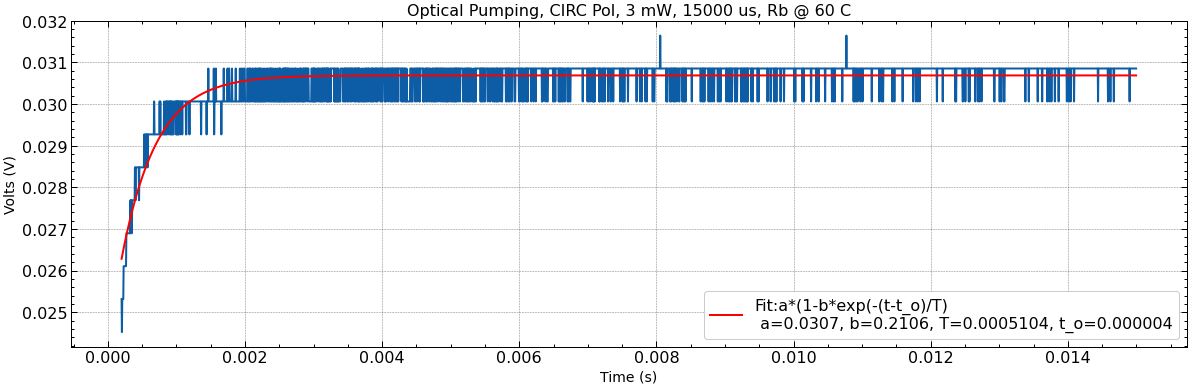

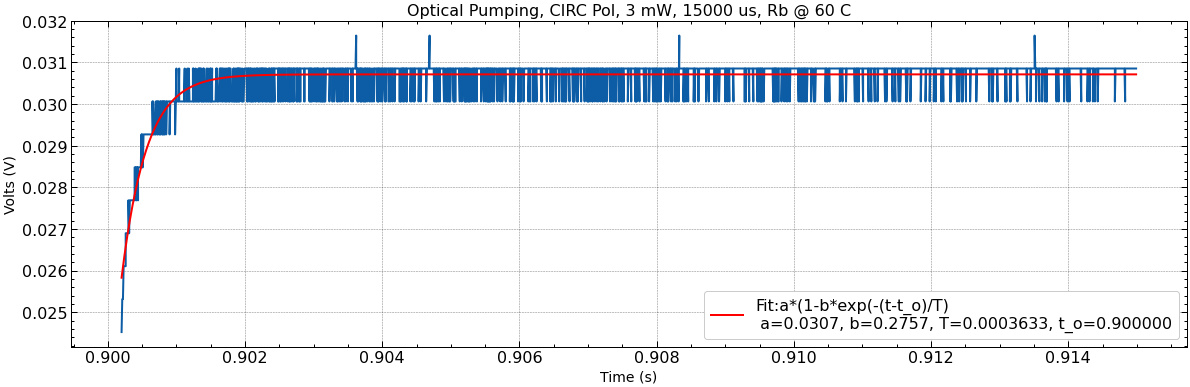

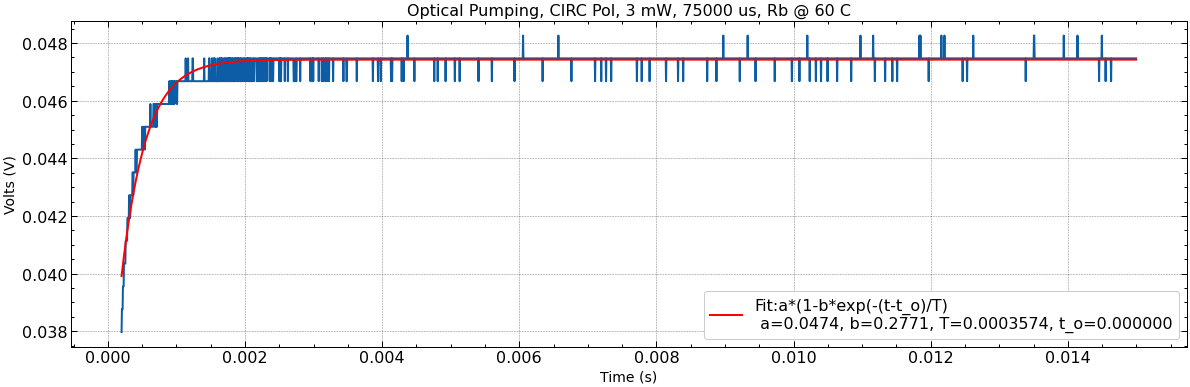

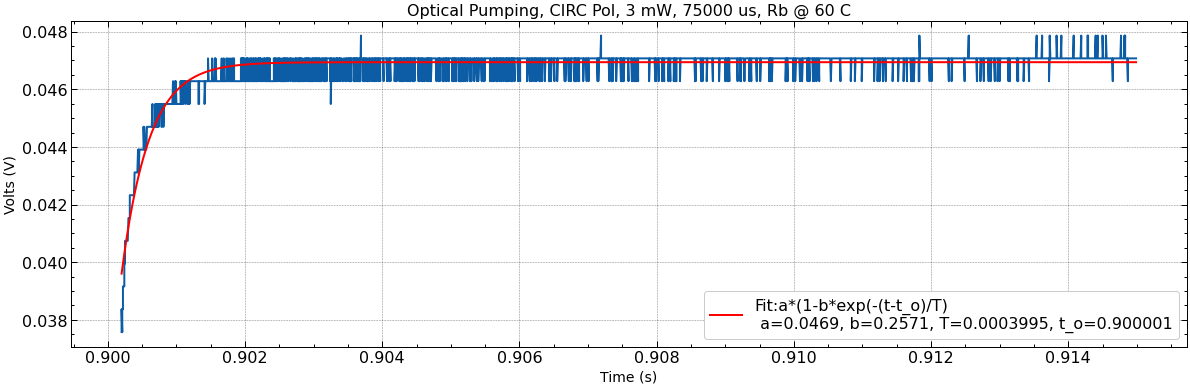

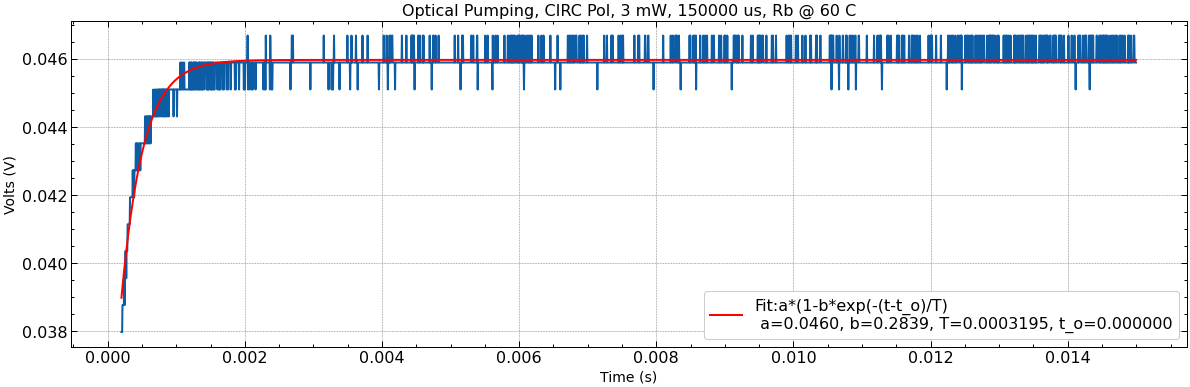

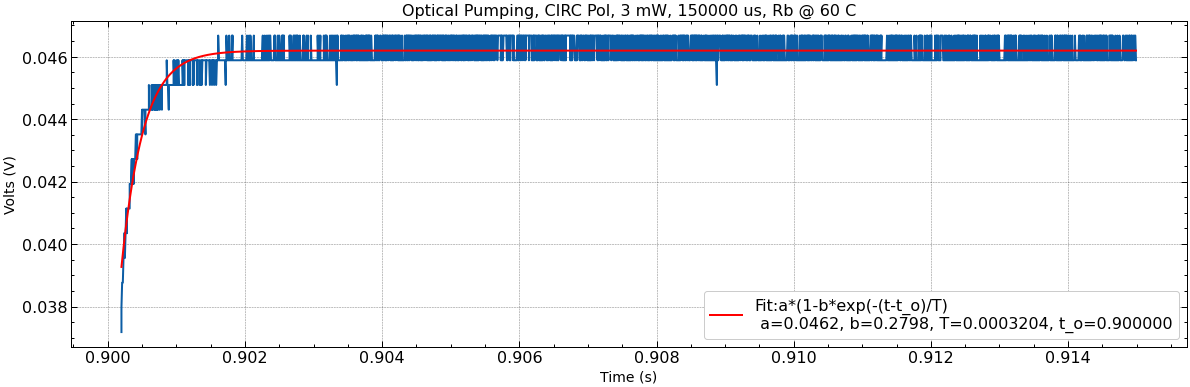

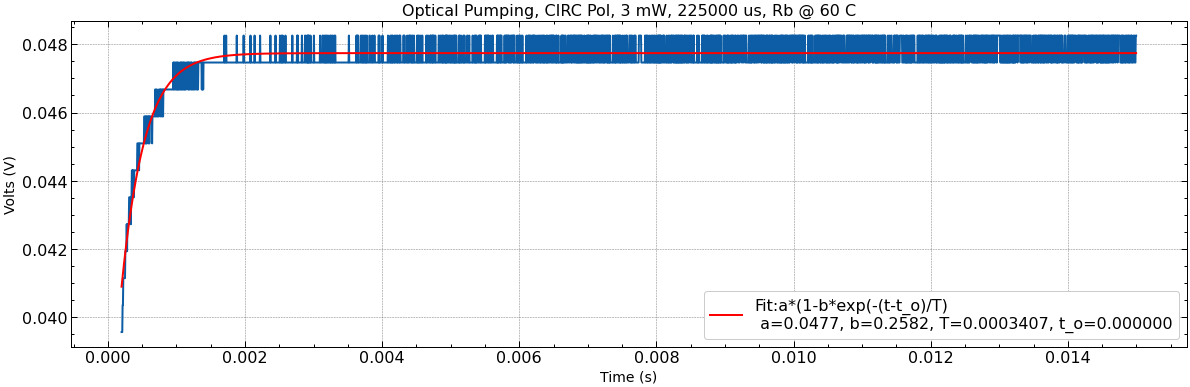

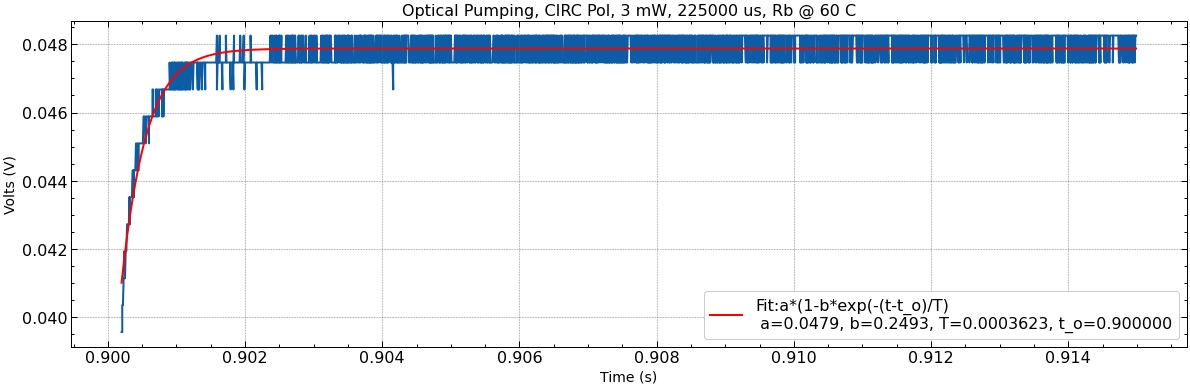

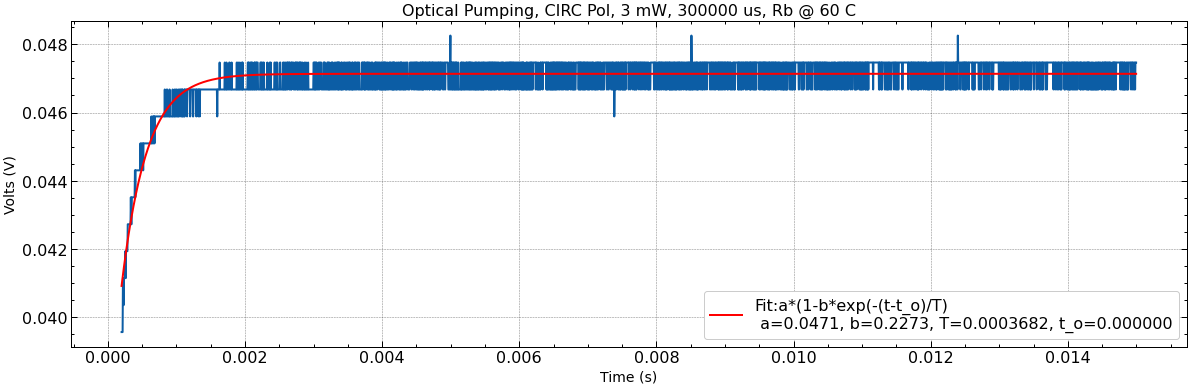

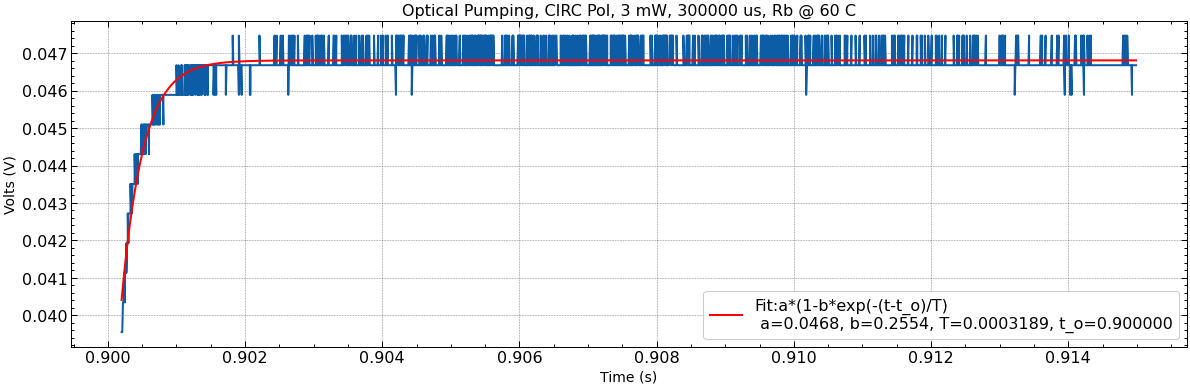

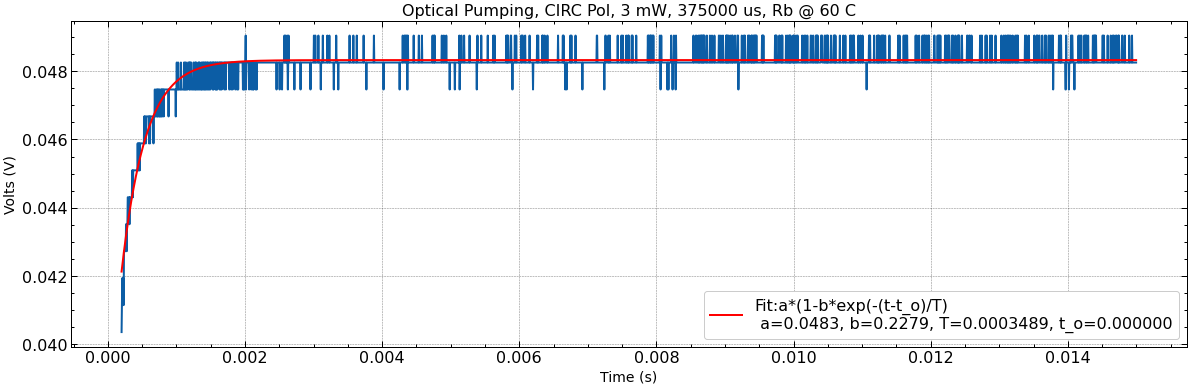

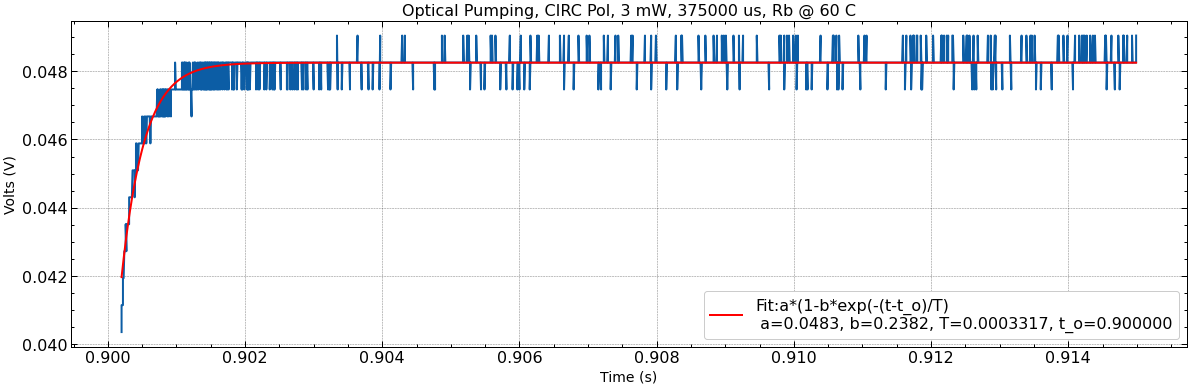

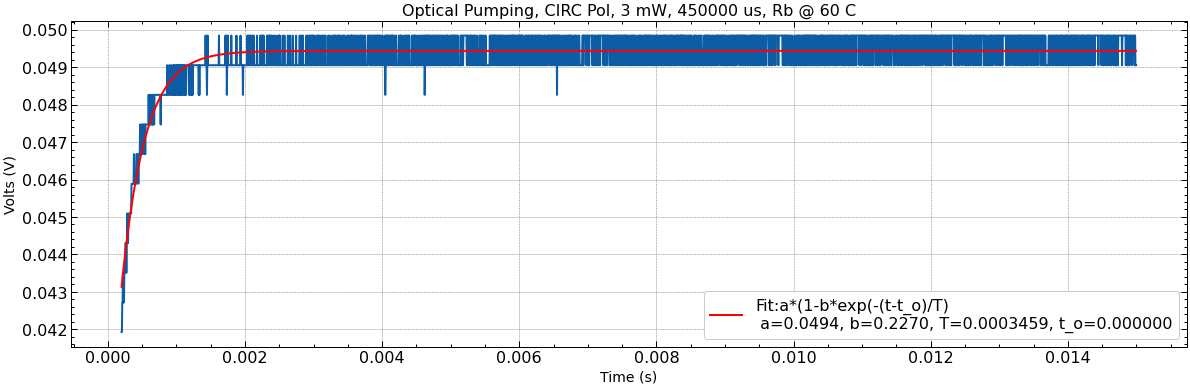

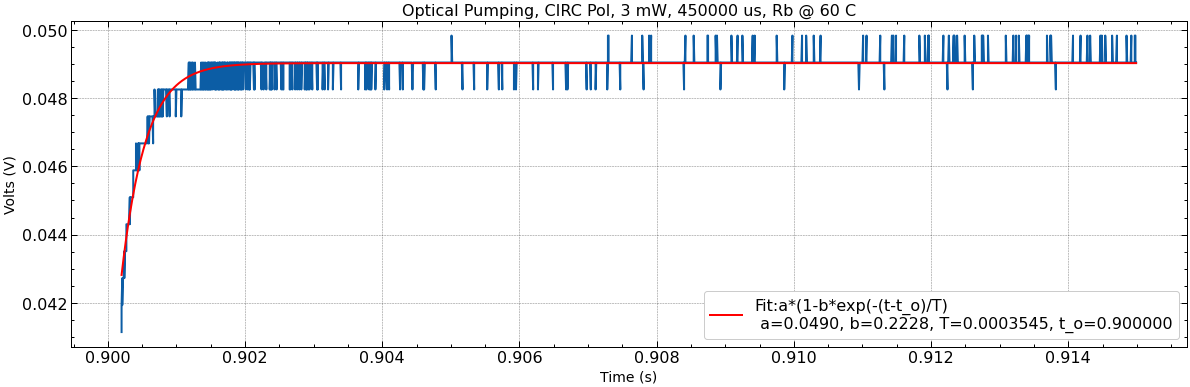

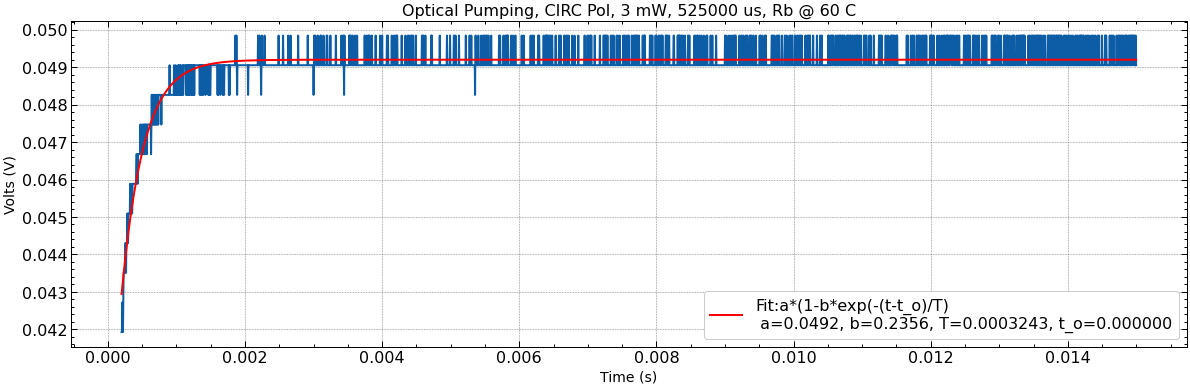

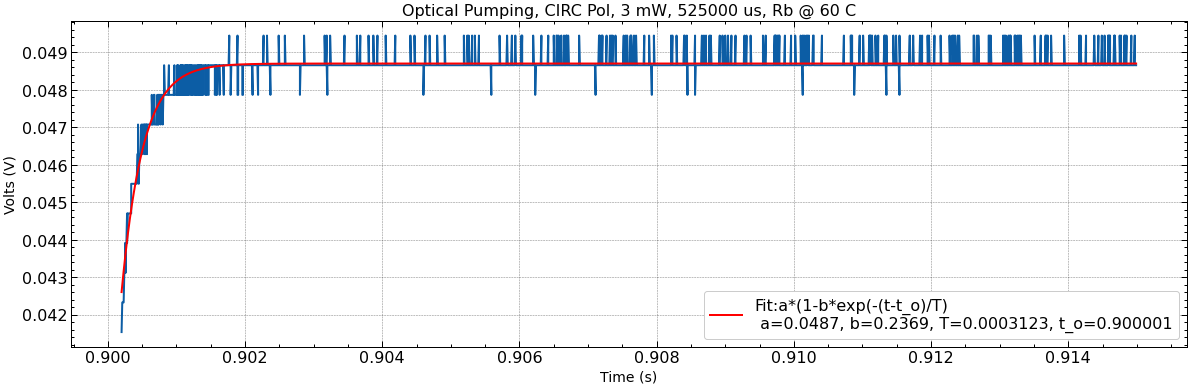

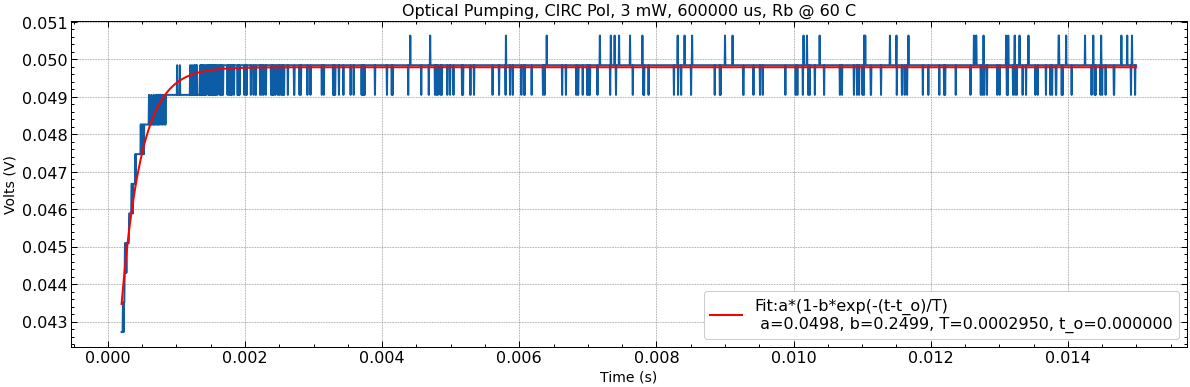

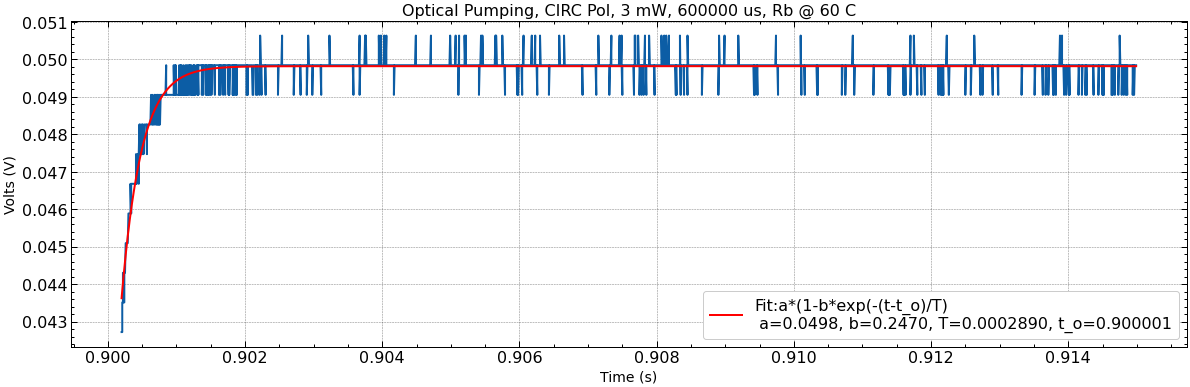

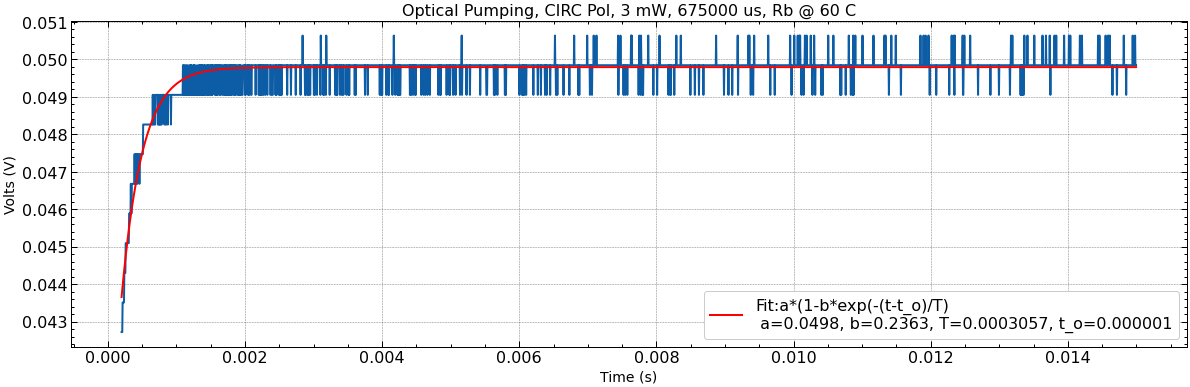

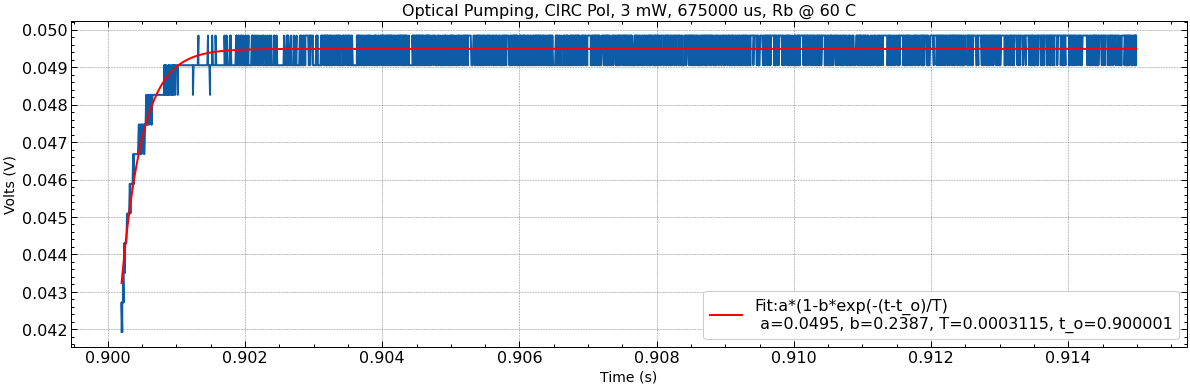

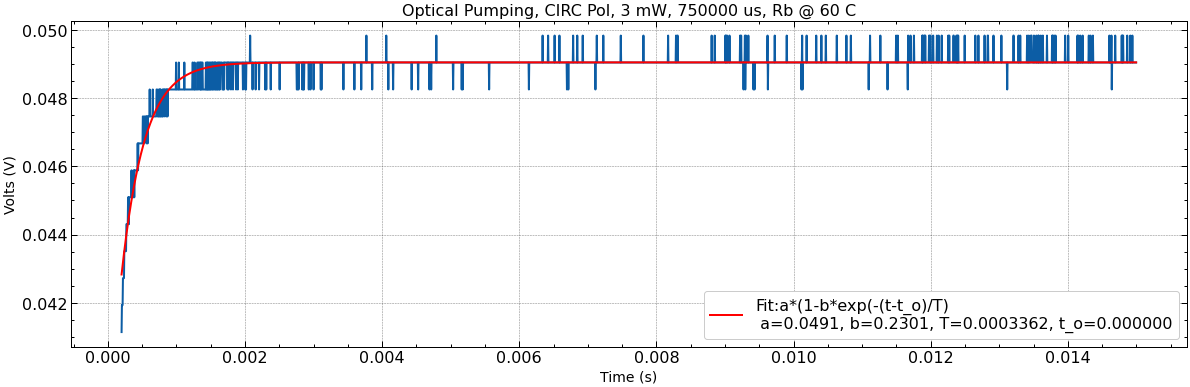

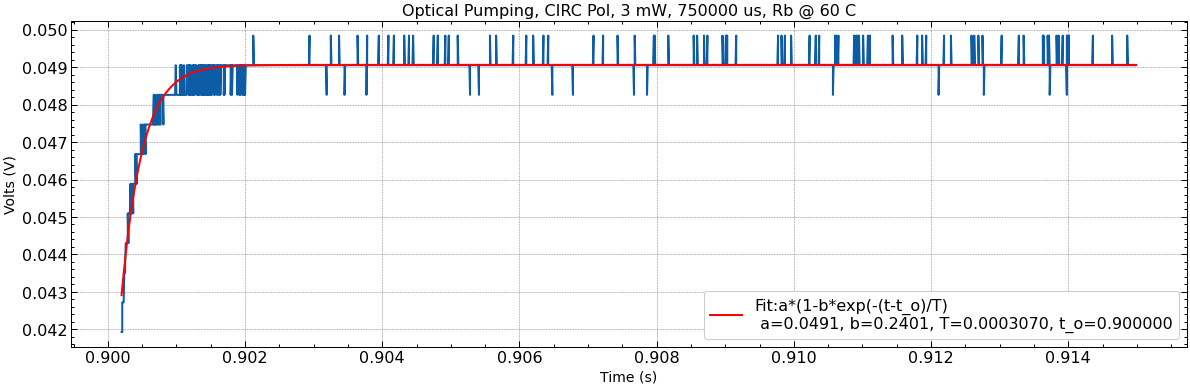

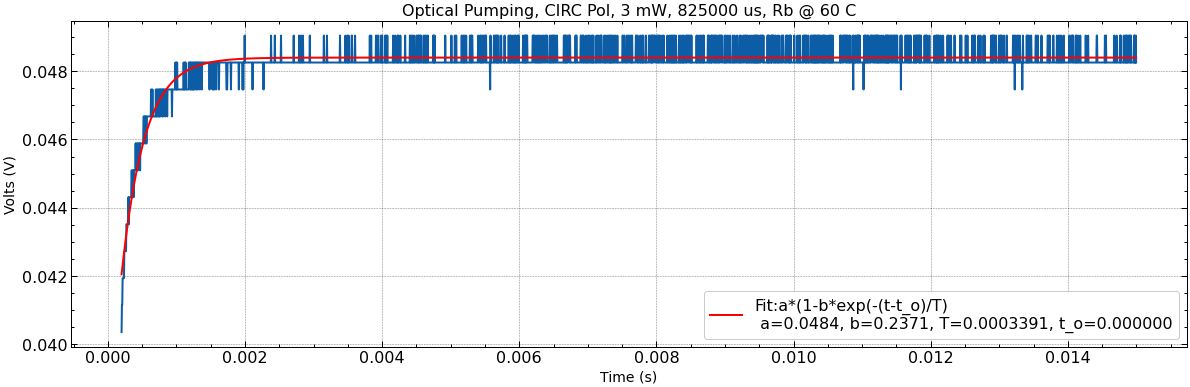

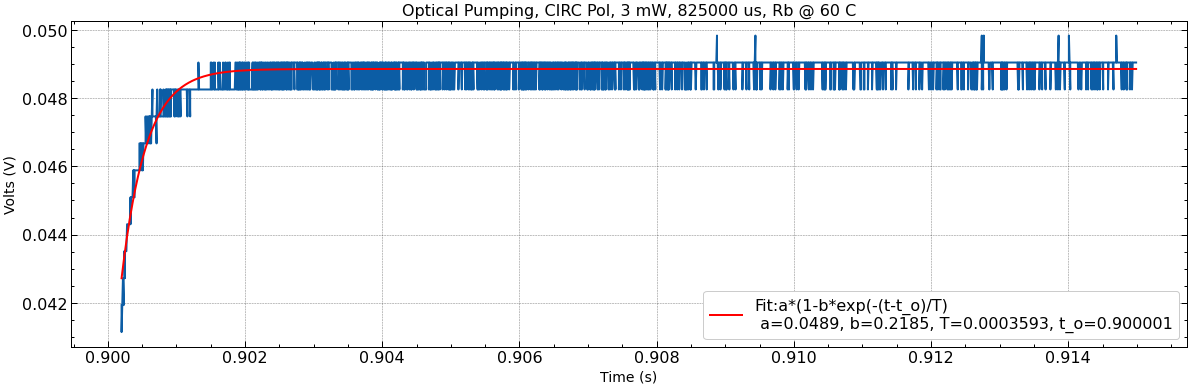

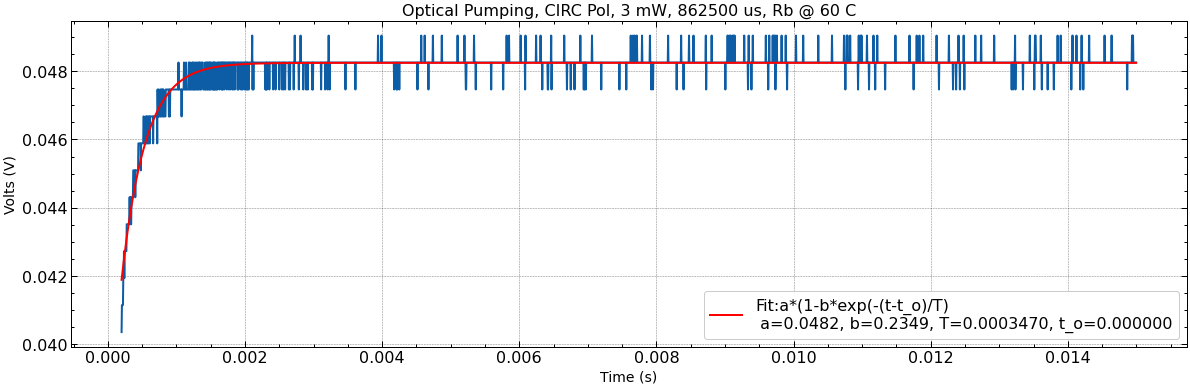

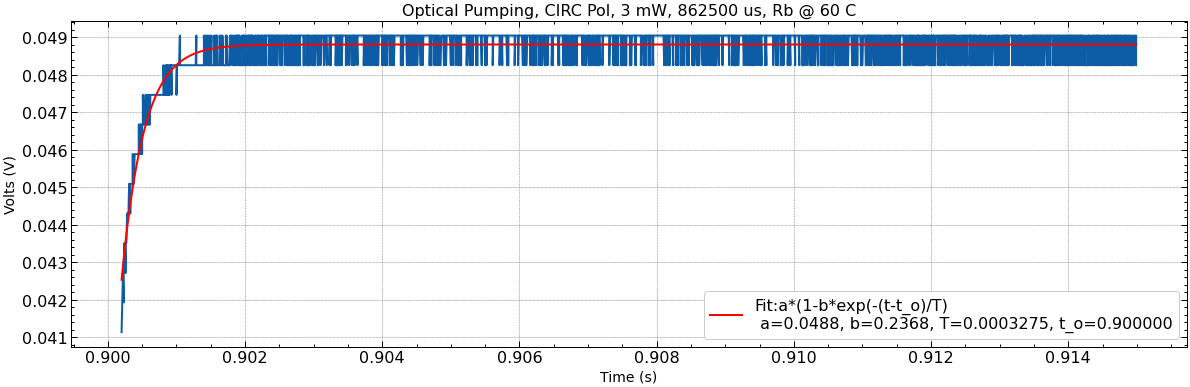

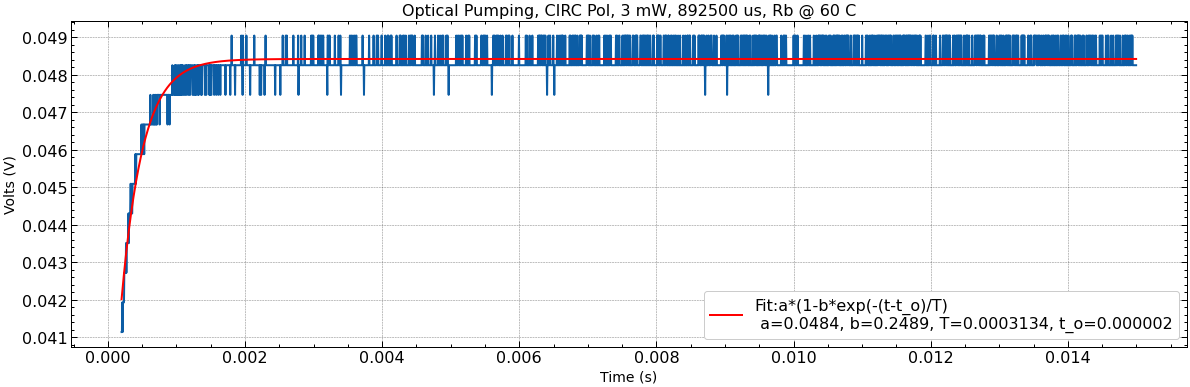

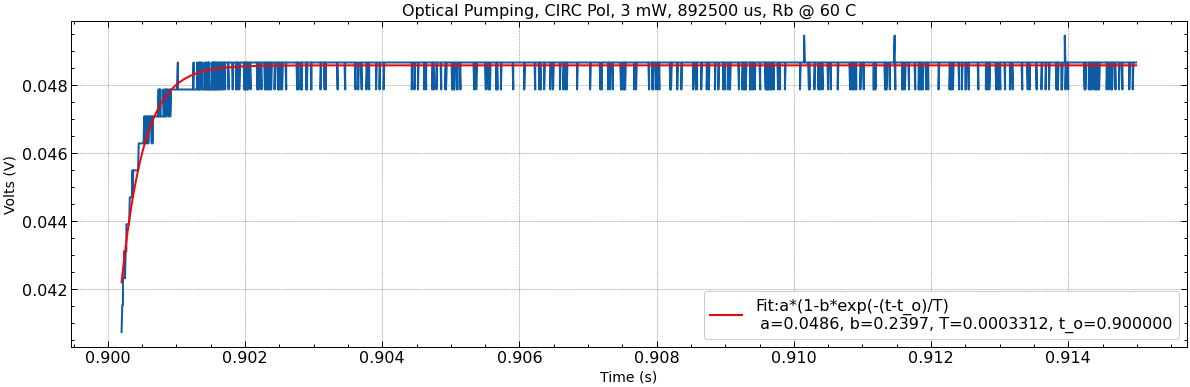

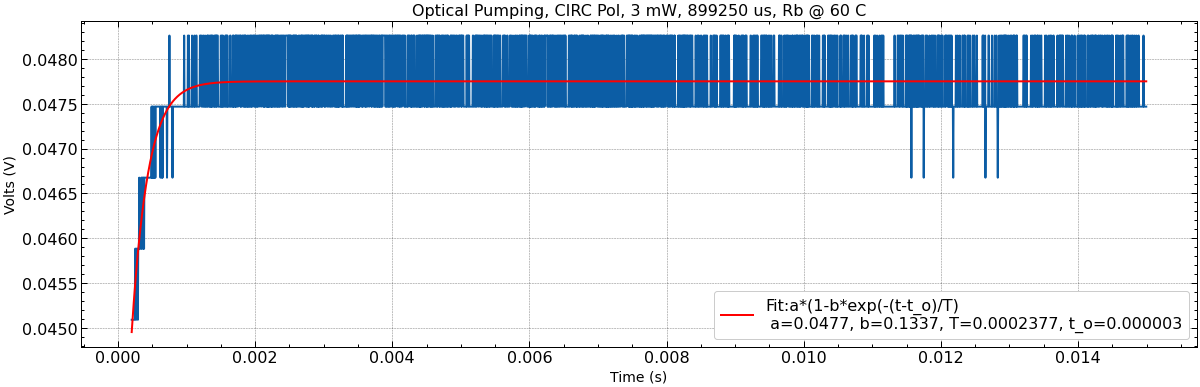

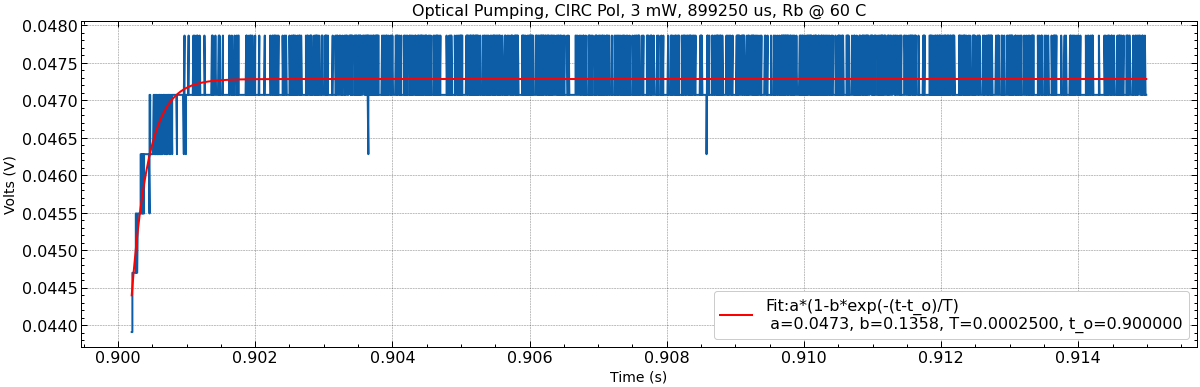

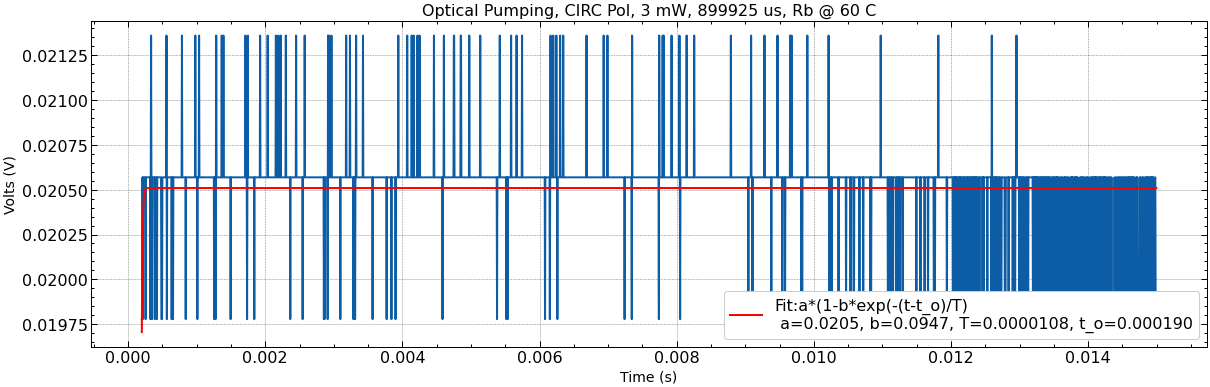

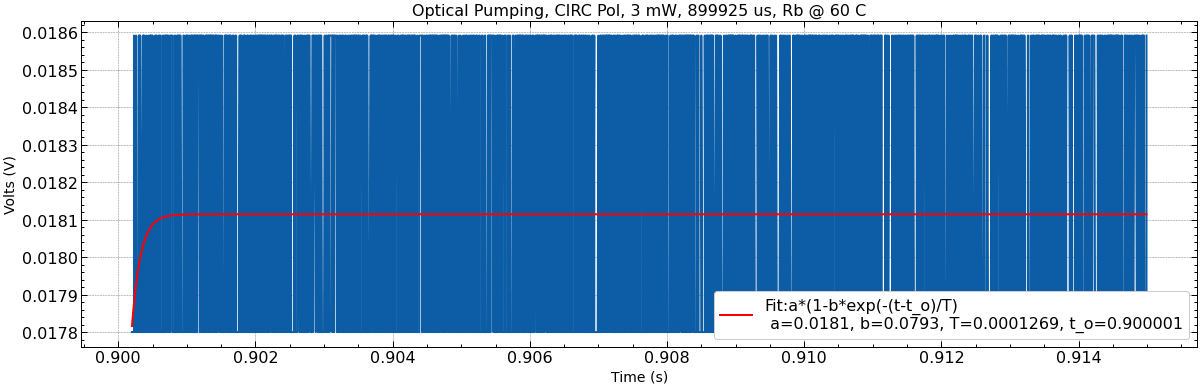

In [244]:
# BRANDLONG = 'PrecisionGlassBlowing'
# BRAND = 'PGB'
# POL = 'CIRC'
# TEMP = '40' 
# root = ("/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/"
#         +f"{BRANDLONG}/{POL}POL/relaxation_time_{TEMP}C_Phase_Locked)
# filenums = [500, 540, 580, 620, 660, 700, 740, 780, 820, 860,900,940,980,1200,1600,2000,2400]
# filenums = [900,940,980,1200,1600,2000,2400]
# filenums = [*range(1540,1620, 40)]
# filenums = [*range(100,5700, 100)] #LINPOL3
# filenums = [*range(100,2400, 100)] #LINPOL2
# pulsewidths = [200, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000,
#                10000, 11000, 11500, 11900, 11990] # 40C Phase Locked
pulsewidths = [15000, 75000, 150000, 225000, 300000, 375000, 450000, 525000,
               600000, 675000, 750000, 825000, 862500, 892500, 899250, 899925]

filenums = [*range(16)]
for filenum in filenums:
    # file1 = "/mnt/c\QuantumRouter\Magnetometery\OPscopetraceCircPol\circ2_3mW0.csv"
#     file1 = "/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/LINPOL3/60C0dB/LIN"+str(filenum)+"uW0.csv"
    # file1 = file1.replace("\\", "/")
#     file1 = ("/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/"
#              "Thorlabs/LINPOL/40C/LIN100uW"+str(filenum)+".csv")
    file = (root+f"/{POL}{str(pulsewidths[0])}us{str(filenum)}.csv")
    print(file)
    # print(time.ctime())
    data = pd.read_csv(file)
    # print(pd.read_csv(file1, nrows=5))
    # print("Shape:")
    # print(data1.shape)
    # print("Dtypes:")
    # print(data1.dtypes)
    print(time.ctime())
    print(filenum)
    pw_measured = pulsewidths[filenum]
#     pw_eval = 200
    pw_eval = 15000 # 60C Phase locked 15ms
    print(pw_measured)
#     # arbitrary us
# data1 = data[(data['Time(s)'] > 0.0) & (data['Time(s)'] < pw_eval(10**(-6)))]
# data2 = cut(data1, 0.0, 1*(10**(-6)))
# # data3  = dfconcat(data1, data2, (17*(10**(-6))), pw_eval(10**(-6)))
# # data3  = dfconcat(data1, data2, (1*(10**(-6))), pw_eval(10**(-6)))s
# data3  = dfconcat(data1, data2, (1.3*(10**(-6))), pw_eval(10**(-6)))
#     # 40C Phase Locked
#     a = (1*(10**(-6)))-5*10**-6
#     b = 1*(10**(-6))
#     c = 1.2*(10**(-6))
#     d = pw_eval*(10**(-6))
#     a = (1*(10**(-6)))-5*10**-6
#     b = 1*(10**(-6))
#     c = 1.2*(10**(-6))
#     d = pw_eval*(10**(-6))
    # 60C Phase locked 15ms
    a = (1*(10**(-6)))-5*10**-6
    b = (1*(10**(-6)))
    c = ((200*(10**(-6))))
    d = (pw_eval*(10**(-6)))
    # 100 us
    offset = 0
    data1 = df_parse(data, 'Time(s)', a, d, offset)
    if contains_negatives(data1['CH2(V)'],'data1'):
        delta = 0.0 - data1['CH2(V)'].min()
        data1.loc[:, 'CH2(V)'] += delta
        print("The data1 Y data values have been normalized w/respect to zero")
        contains_negatives(data1['CH2(V)'],'data1')
    data2 = cut(data1, a+offset, b+offset)
    contains_negatives(data2, 'data2')
#     data3  = dfconcat(data1, data2, (1.25*(10**(-6))), 100*(10**(-6)))
#     data3  = dfconcat(data1, data2, (17*(10**(-6))), pw_eval(10**(-6)))
    data3  = dfconcat(data1, data2, c+offset, d+offset)
    contains_negatives(data3['CH2(V)'], 'data3')
    num = 0
#     fitInitGuess = [0.06, 0.8, (10*10**(-5))+offset, (1*10**(-4))+offset]
#     fitBounds=((0,0.5,0+offset,(0*10**-4)+offset),(5.0, 0.9, 0.001+offset, (1*10**(-3))+offset))
    fitInitGuess = [0.06, 0.8, 0.0001, 0.0001+offset]
    fitBounds=((0, 0, 0, 0+offset),(5.0, 1, 0.001, 0.001+offset))
    fit(data3, file, npy_dir, inv_exp, num, TEMP, POL, BRAND, offset, pw_measured, fitInitGuess, fitBounds)

    #100 us
#     offset = 12000*(10**(-6))
    offset = 900000*(10**(-6)) # 60C Phase locked 15ms
    data1 = df_parse(data, 'Time(s)', a, d, offset)
    if contains_negatives(data1['CH2(V)'],'data1'):
        delta = 0.0 - data1['CH2(V)'].min()
        data1.loc[:, 'CH2(V)'] += delta
        print("The data1 Y data values have been normalized w/respect to zero")
        contains_negatives(data1['CH2(V)'],'data1')
    data2 = cut(data1, a+offset, b+offset)
    contains_negatives(data2, 'data2')
#     data3  = dfconcat(data1, data2, ((1.25*(10**(-6)))+offset), ((100*(10**(-6)))+offset))
#     data3  = dfconcat(data1, data2, ((17*(10**(-6)))+offset), ((pw_eval(10**(-6)))+offset))
    data3  = dfconcat(data1, data2, c+offset, d+offset)
    contains_negatives(data3['CH2(V)'], 'data3')
    num = 1
    
#     fitInitGuess = [0.06, 0.8, (10*10**(-5))+offset, (1*10**(-4))+offset]
#     fitBounds=((0,0.5,0+offset,(0*10**-4)+offset),(5.0, 0.9, 0.001+offset, (1*10**(-3))+offset))
    fitInitGuess = [0.06, 0.8, 0.0001, 0.0001+offset]
    fitBounds=((0, 0, 0, 0+offset),(5.0, 1, 0.001, 0.001+offset))
    fit(data3, file, npy_dir, inv_exp, num, TEMP, POL, BRAND, offset, pw_measured, fitInitGuess, fitBounds)

/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/PrecisionGlassBlowing/CIRCPOL/relaxation_time_60C_Phase_Locked_15ms/CIRC15000us15.csv
Fri Jan 20 14:07:24 2023


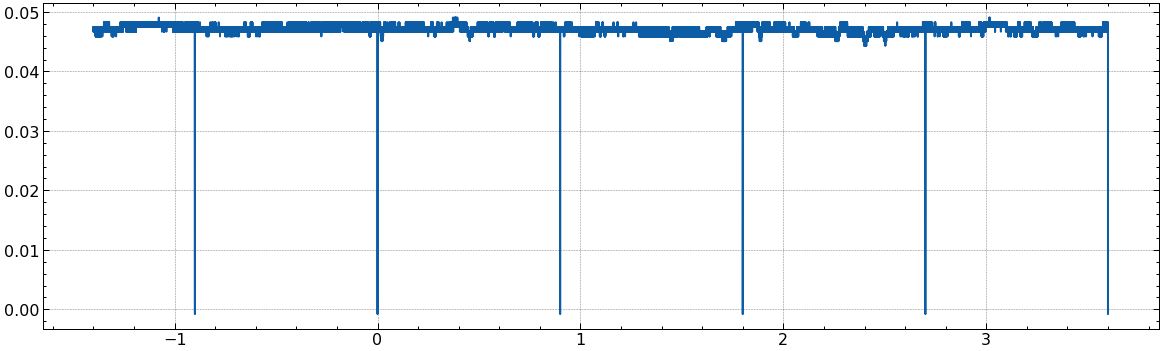

In [242]:
# BRANDLONG = 'PrecisionGlassBlowing'
# BRAND = 'PGB'
# POL = 'CIRC'
# TEMP = '40' 
# root = ("/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/"
#         +f"{BRANDLONG}/{POL}POL/relaxation_time_{TEMP}C_Phase_Locked")
pulsewidths = [15000, 75000, 150000, 225000, 300000, 375000, 450000, 525000,
               600000, 675000, 750000, 825000, 862500, 892500, 899250, 899925]
filenum = 15
file = (root+f"/{POL}{str(pulsewidths[0])}us{str(filenum)}.csv")
# file1 = file1.replace("\\", "/")
print(file)
print(time.ctime())
data = pd.read_csv(file)

fig, ax = plt.subplots(figsize = (20,6), facecolor='w')

ax.plot(data['Time(s)'], data['CH2(V)'], '-')
# tick_spacing = 0.0005
# import matplotlib.ticker as ticker
# ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
pw_measured = pulsewidths[filenum]
pw_eval = 15000
# offset = (1200*(10**(-6)))
# ax.set_xlim(30*(10**(-6)), (0*(10**(-6)))+(pulsewidth*(10**(-6)))) #PGBLIN60
q = 1.3*(10**(-6))
w = pw_eval*(10**(-6))
# ax.set_xlim(q+0-3*10**-6,w+0)
# ax.set_xlim(0*(10**(-6)), 0.0001)
# ax.set_xlim(1*(10**(-6)),1.3*(10**(-6)))
#ax.set_ylim(40000,60000)
ax.grid(True)
# ax.set_xlim(1200*(10**(-6)),1300*(10**(-6)))


# plt.savefig()

There are 0 negative Y values in data1.
The minimum Y value of data1 is: 0.02689808
The average of the Y data in data2: 0.02689808
There are 0 negative Y values in data2.
The minimum Y value of data2 is: 0.0
There are 0 negative Y values in data3.
The minimum Y value of data3 is: 0.0
length data3: 3000
0
899925
best_vals: [2.05047352e-02 5.25112818e-01 2.08914147e-05 1.07255558e-05] covar: [[ 2.74654910e-11  2.61553611e-02  1.17856073e-13 -1.04021003e-06]
 [ 2.61553611e-02  7.25919221e+10  7.55158503e-03 -2.88701229e+06]
 [ 1.17856073e-13  7.55158503e-03  1.72687655e-13 -3.00329797e-07]
 [-1.04021003e-06 -2.88701229e+06 -3.00329797e-07  1.14817733e+02]]


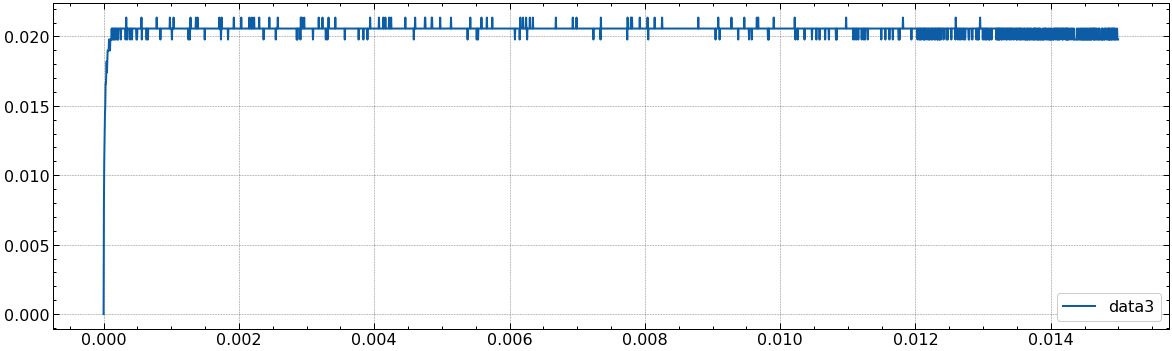

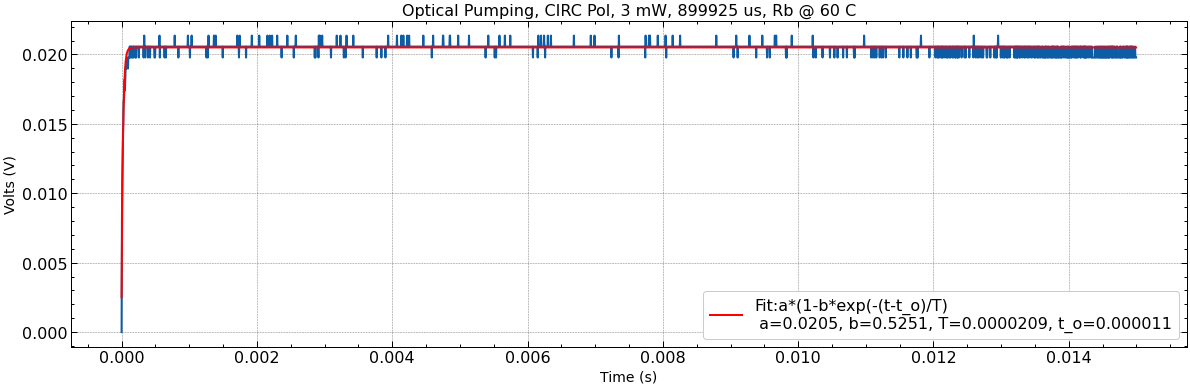

In [236]:
# #20us
# (20*(10**(-6)))-((1.25*(10**(-6)))) # pulse width minus curve start = 1.875e-05
# (1.25*(10**(-6))) - (1*(10**(-6))) # curve start minus cut stop (rise time) = 2.4999999999999994e-07
# 1*(10**(-6)) # pulse window start (cut start) to cut stop

# data1 = data[(data['Time(s)'] > 0.0) & (data['Time(s)'] < 20*(10**(-6)))]
# data2 = cut(data1, 0.0, 1*(10**(-6)))
# data3  = dfconcat(data1, data2, (1.25*(10**(-6))), 20*(10**(-6)))

# 100 us
# data1 = data[(data['Time(s)'] > 0.0) & (data['Time(s)'] < 100*(10**(-6)))]
# data2 = cut(data1, 0.0, 1*(10**(-6)))
# data3  = dfconcat(data1, data2, (1.25*(10**(-6))), 100*(10**(-6)))

# # arbitrary us
# data1 = data[(data['Time(s)'] > 0.0) & (data['Time(s)'] < 50*(10**(-6)))]
# data2 = cut(data1, 0.0, 1*(10**(-6)))
# data3  = dfconcat(data1, data2, (1.25*(10**(-6))), 50*(10**(-6)))

# # arbitrary us
# #PGBLIN60
# a = (30*(10**(-6)))
# b = (pulsewidth*(10**(-6)))
# c = (25*(10**(-6)))
# d = 0.0
# data1 = data[(data['Time(s)'] > d) & (data['Time(s)'] < b)]
# print('data1: ', np.isinf(data1).values.sum(), data1.isnull().sum().sum(), data1.isnull().values.any())
# data2 = cut(data1, d, c)
# print('data2: ', np.isinf(data2).values.sum(), data2.isnull().sum().sum(), data2.isnull().values.any())
# # data1 = data[(data['Time(s)'] > 0.0) & (data['Time(s)'] < pulsewidth*(10**(-6)))]
# # data2 = cut(data1, 0.0, 1*(10**(-6)))
# data3  = dfconcat(data1, data2, a, b)
# print('data3: ', np.isinf(data3).values.sum(), data3.isnull().sum().sum(), data3.isnull().values.any())
# # data3  = dfconcat(data1, data2, (17*(10**(-6))), pulsewidth*(10**(-6)))
# # data3  = dfconcat(data1, data2, (1*(10**(-6))), pulsewidth*(10**(-6)))s
# # data3  = dfconcat(data1, data2, (1.3*(10**(-6))), pulsewidth*(10**(-6)))

# # arbitrary us
# offset = -(1200*(10**(-6)))
offset = 0

a = (1*(10**(-6)))-5*10**-6
b = (1*(10**(-6)))
c = ((200*(10**(-6))))-0.0002
d = (pw_eval*(10**(-6)))

# def contains_negatives(df_col, name):
#     count = len(df_col < 0)
#     print(f'There are {count} negative Y values in {name}.')
#     print(f'The minimum Y value of {name} is:', df_col.min())
#     if count == 0: 
#         return False
#     else:
#         return True

data1 = df_parse(data, 'Time(s)', a, d, offset)
if contains_negatives(data1['CH2(V)'],'data1'):
    delta = 0.0 - data1['CH2(V)'].min()
    print("delta:", delta)
    data1.loc[:, 'CH2(V)'] += delta
    print("The data1 Y data values have been normalized w/respect to zero")
    contains_negatives(data1['CH2(V)'],'data1')

# create the data before the pulse(a-b) and compare average to pulse (c-d)
# before_pulse = df_parse(data, 'Time(s)', a, b, offset)

data2 = cut(data1, a+offset, b+offset)
contains_negatives(data2, 'data2')

data3  = dfconcat(data1, data2, c+offset, d+offset)
# The minimum value in data 3 must be greater than or equal to the average
# in data2 (from which all of data1, including the subset data3, is subtracted)
# if the minimum in data3 is not greater than or eqaul to the average in data2
# than the lower x boudary (variable c) likely must be increased
# thus, before subtracting data1 from the average of data2, it must be
# compared to the data 3 min. This means that data3 must be isolated before
# it is normalzed with respect to the data2 average to ensure it doesn't
# yield negative values in data3.
contains_negatives(data3['CH2(V)'], "data3")
print('length data3:', len(data3.index))

fig, ax = plt.subplots(figsize = (20,6), facecolor='w')
# ax.plot(data1['Time(s)'], data1['CH2(V)'], '-', label='data1')
ax.plot(data3['Time(s)'], data3['CH2(V)'], '-', label='data3')
plt.legend(loc='best')
# ax.set_xlim(a, b)

# BRANDLONG = 'PrecisionGlassBlowing'
# BRAND = 'PGB'
# POL = 'LIN'
# TEMP = '40'
num = 0

# print(a,b)
# fitInitGuess = [0.06, 0.8, (10*10**(-5))+offset, (1*10**(-4))+offset]
# fitBounds=((0,0.5,0+offset,(0*10**-4)+offset),(5.0, 0.9, 0.001+offset, (1*10**(-3))+offset))
fitInitGuess = [0.06, 0.8, 0.0001, 0.0001+offset]
fitBounds=((0, 0.5, 0, 0+offset),(5.0, 0.9, 0.001, 0.001+offset))
fit(data3, file, npy_dir, inv_exp, num, TEMP, POL, BRAND, offset, pw_measured, fitInitGuess, fitBounds)

data:  0 0 False
data1:  0 0 False
The average of the Y data in data2: 0.02887588
data2:  0 0 False
data3:  0 0 False
length data3: 3000
1
899925
best_vals: [1.81067030e-02 5.29148374e-01 1.96183288e-05 9.00011551e-01] covar: [[5.62505214e-11 3.91501434e-18 2.13818505e-13 1.05636197e-13]
 [3.91501434e-18 1.32883771e-22 3.38306002e-18 3.58552162e-18]
 [2.13818505e-13 3.38306002e-18 3.03125180e-13 9.12830413e-14]
 [1.05636197e-13 3.58552162e-18 9.12830413e-14 9.67459394e-14]]


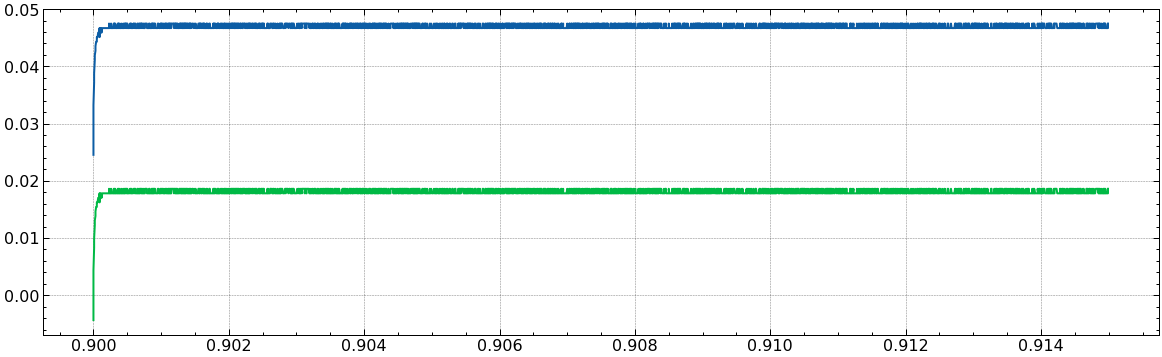

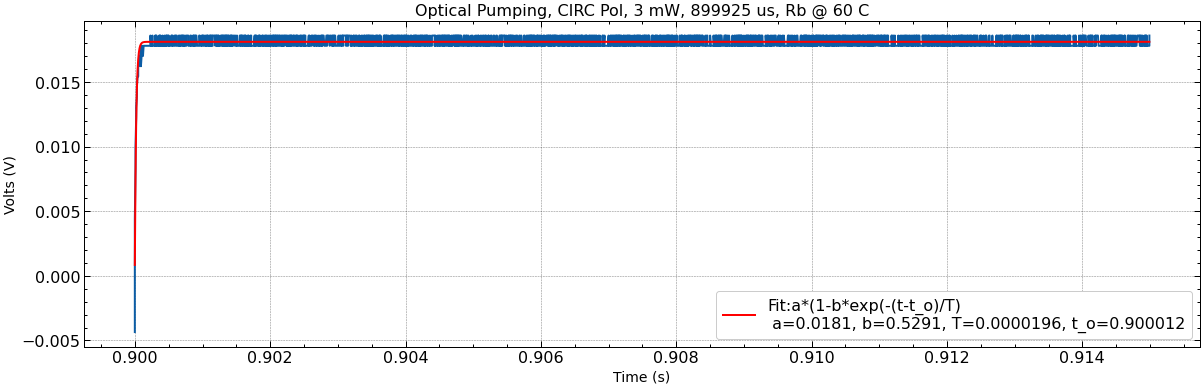

In [237]:
# offset = (1200*(10**(-6)))
offset = ((900000)*(10**(-6)))

# #20us
# data1 = data[(data['Time(s)'] > (0.0+offset)) & (data['Time(s)'] < ((20*(10**(-6)))+offset))]
# data2 = cut(data1, (0.0+offset), ((1*(10**(-6)))+offset))
# data3  = dfconcat(data1, data2, ((1.25*(10**(-6)))+offset), ((20*(10**(-6)))+offset))

# #100 us
# data1 = data[(data['Time(s)'] > (0.0+offset)) & (data['Time(s)'] < ((50*(10**(-6)))+offset))]
# data2 = cut(data1, (0.0+offset), ((1*(10**(-6)))+offset))
# data3  = dfconcat(data1, data2, ((1.25*(10**(-6)))+offset), ((50*(10**(-6)))+offset))

# arbitrary us
# a = (30*(10**(-6)))
# b = a + (pulsewidth*(10**(-6)))
# c = (25*(10**(-6)))
# d = 0.0
# data1 = data[(data['Time(s)'] > d) & (data['Time(s)'] < b)]

# data2 = cut(data1, d, c)

# data3  = dfconcat(data1, data2, a, b)

#100 us
# ls = (1*(10**(-6)))
# a = a-3*10**-6
# c = c-3*10**-6
# d = d-3*10**-6

print('data: ', np.isinf(data).values.sum(), data.isnull().sum().sum(), data.isnull().values.any())
data1 = data[(data['Time(s)'] > (a+offset)) & (data['Time(s)'] < (d+offset))]
# data1 = df_parse(data, 'Time(s)', a, d, offset)
print('data1: ', np.isinf(data1).values.sum(), data1.isnull().sum().sum(), data1.isnull().values.any())
data2 = cut(data1, (a+offset), (b+offset))
print('data2: ', np.isinf(data2).values.sum(), data2.isnull().sum().sum(), data2.isnull().values.any())
data3  = dfconcat(data1, data2, ((c)+offset), (d)+offset)
print('data3: ', np.isinf(data3).values.sum(), data3.isnull().sum().sum(), data3.isnull().values.any())
print('length data3:', len(data3))
# #100 us
# data1 = data[(data['Time(s)'] > (0.0+offset)) & (data['Time(s)'] < ((pulsewidth*(10**(-6)))+offset))]
# data2 = cut(data1, (0.0+offset), ((1*(10**(-6)))+offset))
# # data3  = dfconcat(data1, data2, ((17*(10**(-6)))+offset), ((pulsewidth*(10**(-6)))+offset))
# # data3  = dfconcat(data1, data2, ((1*(10**(-6)))+offset), ((pulsewidth*(10**(-6)))+offset))
# data3  = dfconcat(data1, data2, ((1.2*(10**(-6)))+offset), ((pulsewidth*(10**(-6)))+offset))
# data_new = pd.concat([data1['Time(s)'], data2], axis=1)

fig, ax = plt.subplots(figsize = (20,6), facecolor='w')

ax.plot(data1['Time(s)'], data1['CH2(V)'], '-')
# ax.plot(data_new['Time(s)'], data_new['CH2(V)'], '-')
ax.plot(data3['Time(s)'], data3['CH2(V)'], '-')
# ax.set_xlim(1.2*(10**(-6)), (2*(10**(-6))))

# BRANDLONG = 'PrecisionGlassBlowing'
# BRAND = 'PGB'
# POL = 'LIN'
# TEMP = '40'
num = 1
# offset = 0.9
# fitInitGuess = [0.06, 0.8, (10*10**(-5))+offset, (1*10**(-4))+offset]
# fitBounds=((0,0.5,0+offset,(0*10**-4)+offset),(5.0, 0.9, 0.001+offset, (1*10**(-3))+offset))
# fitInitGuess = [0.06, 0.8, 0.0001, 0.9]
# fitBounds=((0, 0.5, 0, 0+offset),(5.0, 0.9, 0.001, 0.9+0.001))
fitInitGuess = [0.06, 0.8, 0.0001, 0.0001+offset]
fitBounds=((0, 0.5, 0, 0+offset),(5.0, 0.9, 0.001, 0.001+offset))
fit(data3, file, npy_dir, inv_exp, num, TEMP, POL, BRAND, offset, pw_measured, fitInitGuess, fitBounds)

In [254]:
# pulsewidths = [20, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1150, 1190, 1199] 
fnums = [*range(16)]
b_list = []
for fnum in fnums:
    b_prime = np.load(npydir+f"/{POL}{str(pulsewidths[0])}us{str(fnum)}_{BRAND}{POL}{TEMP}_RT_{str(pulsewidths[fnum])}us_0_best_vals.npy")[1]
    b = np.load(npydir+f"/{POL}{str(pulsewidths[0])}us{str(fnum)}_{BRAND}{POL}{TEMP}_RT_{str(pulsewidths[fnum])}us_1_best_vals.npy")[1]
    b_list.append((b-b_prime)/b)
    print('b:', b,'b_prime:', b_prime)

b_list, len(b_list), len(pulsewidths)

b: 0.2756870878760668 b_prime: 0.21061484164311803
b: 0.2570828154944468 b_prime: 0.27707620357808543
b: 0.2798211982419415 b_prime: 0.28393724727435327
b: 0.24931091363283447 b_prime: 0.25821412933624865
b: 0.25542366747771433 b_prime: 0.22734832408483166
b: 0.2381848222038438 b_prime: 0.2278633705267393
b: 0.22276887267467446 b_prime: 0.2270083928035598
b: 0.23694017901251807 b_prime: 0.23556625970535153
b: 0.24702306530786663 b_prime: 0.24987659946582857
b: 0.23874484377420074 b_prime: 0.236339704030835
b: 0.24013079790369865 b_prime: 0.2300852990740793
b: 0.21850115115002594 b_prime: 0.23706653198517103
b: 0.23680119151215645 b_prime: 0.2348571160270341
b: 0.23971789130978646 b_prime: 0.24894453706431907
b: 0.13581207833134218 b_prime: 0.13368252930280927
b: 0.07929697817985222 b_prime: 0.0946638112689606


([0.2360366121397806,
  -0.07777022375138305,
  -0.014709568318169,
  -0.035711295481136204,
  0.1099167656236564,
  0.043333792563285865,
  -0.019031025645475264,
  0.005798591496353838,
  -0.011551691152425624,
  0.010074101309766737,
  0.04183344626059993,
  -0.08496697036803176,
  0.008209736921963702,
  -0.03848960002158976,
  0.015680115161314467,
  -0.1937883818757269],
 16,
 16)

In [255]:
period_us = int(offset/10**-6)
Tau_list = [period_us-pw for pw in pulsewidths]
Tau_list, len(Tau_list)

([885000,
  825000,
  750000,
  675000,
  600000,
  525000,
  450000,
  375000,
  300000,
  225000,
  150000,
  75000,
  37500,
  7500,
  750,
  75],
 16)

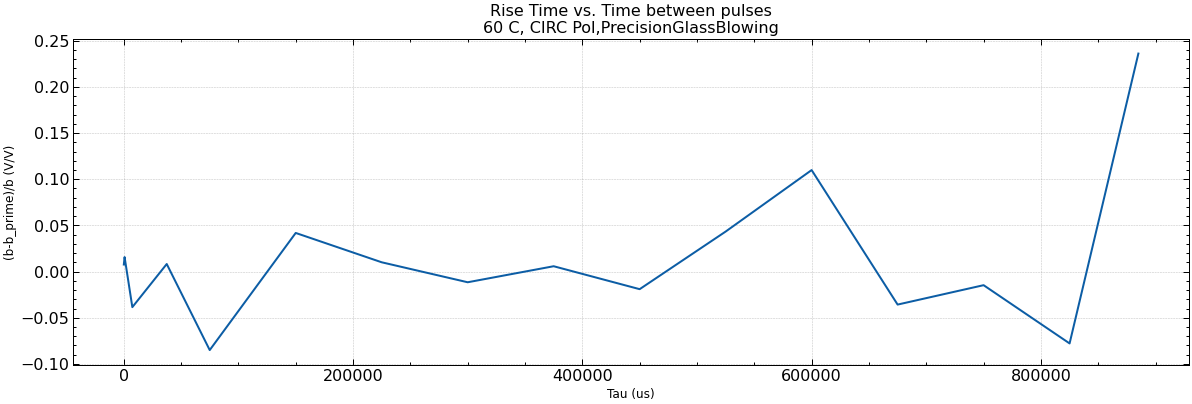

In [240]:
fig, ax = plt.subplots(figsize = (20,6), facecolor='w')

ax.plot(Tau_list,b_list, '-')

ax.set_xlabel('Tau (us)', fontsize=12)
ax.set_ylabel('(b-b_prime)/b (V/V)', fontsize=12)
# ax.invert_xaxis()
ax.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
ax.set_title('Rise Time vs. Time between pulses\n'+TEMP+' C, '+POL+' Pol,'+BRANDLONG)
plt.savefig(root+f"/bvTau.png")

In [262]:
BRANDLONG = 'Thorlabs'
BRAND='Thor'
POL='CIRC'

root = ("/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/"
        +f"{BRANDLONG}/{POL}POL/relaxation_time_{TEMP}C")

npydir = (root+"/npy_files")



# TEMP='35'
# globals()[BRAND+POL+TEMP+'_pulsewidths'] = [20, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1150, 1190, 1199]
# fnums = [*range(15)]
# globals()[BRAND+POL+TEMP+'b_list'] = []
# for fnum in fnums:
#     b_prime = np.load(POL+'20us'+str(fnum)+'_'+BRAND+POL+TEMP+'_RT_'+str(globals()[BRAND+POL+TEMP+'_pulsewidths'][fnum])+'us_'+str(0)+'_best_vals.npy')[1]
#     b = np.load(POL+'20us'+str(fnum)+'_'+BRAND+POL+TEMP+'_RT_'+str(globals()[BRAND+POL+TEMP+'_pulsewidths'][fnum])+'us_'+str(1)+'_best_vals.npy')[1]
#     globals()[BRAND+POL+TEMP+'b_list'].append((b-b_prime)/b)
    
# globals()[BRAND+POL+TEMP+'Tau_list'] = [1200-pw for pw in globals()[BRAND+POL+TEMP+'_pulsewidths']]    


# TEMP='40'
# globals()[BRAND+POL+TEMP+'_pulsewidths'] = [20, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1150, 1190, 1199]
# fnums = [*range(15)]
# globals()[BRAND+POL+TEMP+'b_list'] = []
# for fnum in fnums:
#     b_prime = np.load(POL+'20us'+str(fnum)+'_'+BRAND+POL+TEMP+'_RT_'+str(globals()[BRAND+POL+TEMP+'_pulsewidths'][fnum])+'us_'+str(0)+'_best_vals.npy')[1]
#     b = np.load(POL+'20us'+str(fnum)+'_'+BRAND+POL+TEMP+'_RT_'+str(globals()[BRAND+POL+TEMP+'_pulsewidths'][fnum])+'us_'+str(1)+'_best_vals.npy')[1]
#     globals()[BRAND+POL+TEMP+'b_list'].append((b-b_prime)/b)
    
# globals()[BRAND+POL+TEMP+'Tau_list'] = [1200-pw for pw in globals()[BRAND+POL+TEMP+'_pulsewidths']]


TEMP='60'
globals()[BRAND+POL+TEMP+'_pulsewidths'] = [20, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1150, 1190, 1199]
fnums = [*range(15)]
globals()[BRAND+POL+TEMP+'b_list'] = []
for fnum in fnums:
    if fnum != 11:
        b_prime = np.load(npydir+'/'+POL+str(globals()[BRAND+POL+TEMP+'_pulsewidths'][0])+'us'+str(fnum)+'_'+BRAND+POL+TEMP+'_RT_'+str(globals()[BRAND+POL+TEMP+'_pulsewidths'][fnum])+'us_'+str(0)+'_best_vals.npy')[1]
        b = np.load(npydir+'/'+POL+str(globals()[BRAND+POL+TEMP+'_pulsewidths'][0])+'us'+str(fnum)+'_'+BRAND+POL+TEMP+'_RT_'+str(globals()[BRAND+POL+TEMP+'_pulsewidths'][fnum])+'us_'+str(1)+'_best_vals.npy')[1]
        globals()[BRAND+POL+TEMP+'b_list'].append((b-b_prime)/b)
    
globals()[BRAND+POL+TEMP+'_pulsewidths'].remove(1100)
globals()[BRAND+POL+TEMP+'Tau_list'] = [1200-pw for pw in globals()[BRAND+POL+TEMP+'_pulsewidths']]

# POL='LIN'

# TEMP='35'
# globals()[BRAND+POL+TEMP+'_pulsewidths'] = [20, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1150, 1190, 1199]
# fnums = [*range(15)]
# globals()[BRAND+POL+TEMP+'b_list'] = []
# for fnum in fnums:
#     b_prime = np.load(POL+'20us'+str(fnum)+'_'+BRAND+POL+TEMP+'_RT_'+str(globals()[BRAND+POL+TEMP+'_pulsewidths'][fnum])+'us_'+str(0)+'_best_vals.npy')[1]
#     b = np.load(POL+'20us'+str(fnum)+'_'+BRAND+POL+TEMP+'_RT_'+str(globals()[BRAND+POL+TEMP+'_pulsewidths'][fnum])+'us_'+str(1)+'_best_vals.npy')[1]
#     globals()[BRAND+POL+TEMP+'b_list'].append((b-b_prime)/b)
    
# globals()[BRAND+POL+TEMP+'Tau_list'] = [1200-pw for pw in globals()[BRAND+POL+TEMP+'_pulsewidths']]    


# TEMP='40'
# globals()[BRAND+POL+TEMP+'_pulsewidths'] = [20, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1150, 1190, 1199]
# fnums = [*range(15)]
# globals()[BRAND+POL+TEMP+'b_list'] = []
# for fnum in fnums:
#     b_prime = np.load(POL+'20us'+str(fnum)+'_'+BRAND+POL+TEMP+'_RT_'+str(globals()[BRAND+POL+TEMP+'_pulsewidths'][fnum])+'us_'+str(0)+'_best_vals.npy')[1]
#     b = np.load(POL+'20us'+str(fnum)+'_'+BRAND+POL+TEMP+'_RT_'+str(globals()[BRAND+POL+TEMP+'_pulsewidths'][fnum])+'us_'+str(1)+'_best_vals.npy')[1]
#     globals()[BRAND+POL+TEMP+'b_list'].append((b-b_prime)/b)
    
# globals()[BRAND+POL+TEMP+'Tau_list'] = [1200-pw for pw in globals()[BRAND+POL+TEMP+'_pulsewidths']]


# TEMP='60'
# globals()[BRAND+POL+TEMP+'_pulsewidths'] = [20, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1150, 1190, 1199]
# fnums = [*range(15)]
# globals()[BRAND+POL+TEMP+'b_list'] = []
# for fnum in fnums:
# #     if fnum != 11:
#     b_prime = np.load(POL+'20us'+str(fnum)+'_'+BRAND+POL+TEMP+'_RT_'+str(globals()[BRAND+POL+TEMP+'_pulsewidths'][fnum])+'us_'+str(0)+'_best_vals.npy')[1]
#     b = np.load(POL+'20us'+str(fnum)+'_'+BRAND+POL+TEMP+'_RT_'+str(globals()[BRAND+POL+TEMP+'_pulsewidths'][fnum])+'us_'+str(1)+'_best_vals.npy')[1]
#     globals()[BRAND+POL+TEMP+'b_list'].append((b-b_prime)/b)
    
# # globals()[BRAND+POL+TEMP+'_pulsewidths'].remove(1100)
# globals()[BRAND+POL+TEMP+'Tau_list'] = [1200-pw for pw in globals()[BRAND+POL+TEMP+'_pulsewidths']]

In [265]:
BRANDLONG = 'PrecisionGlassBlowing'
BRAND='PGB'
POL='CIRC'
TEMP='60'

root = ("/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/"
        +f"{BRANDLONG}/{POL}POL/relaxation_time_{TEMP}C_Phase_Locked_15ms")

npydir = (root+"/npy_files")
    
# TEMP='35'
# globals()[BRAND+POL+TEMP+'_pulsewidths'] = [20, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1150, 1190, 1199]
# fnums = [*range(15)]
# globals()[BRAND+POL+TEMP+'b_list'] = []
# for fnum in fnums:
#     b_prime = np.load(POL+'20us'+str(fnum)+'_'+BRAND+POL+TEMP+'_RT_'+str(globals()[BRAND+POL+TEMP+'_pulsewidths'][fnum])+'us_'+str(0)+'_best_vals.npy')[1]
#     b = np.load(POL+'20us'+str(fnum)+'_'+BRAND+POL+TEMP+'_RT_'+str(globals()[BRAND+POL+TEMP+'_pulsewidths'][fnum])+'us_'+str(1)+'_best_vals.npy')[1]
#     globals()[BRAND+POL+TEMP+'b_list'].append((b-b_prime)/b)
    
# globals()[BRAND+POL+TEMP+'Tau_list'] = [1200-pw for pw in globals()[BRAND+POL+TEMP+'_pulsewidths']]    


# TEMP='40'
# globals()[BRAND+POL+TEMP+'_pulsewidths'] = [20, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1150, 1190, 1199]
# fnums = [*range(15)]
# globals()[BRAND+POL+TEMP+'b_list'] = []
# for fnum in fnums:
#     b_prime = np.load(POL+'20us'+str(fnum)+'_'+BRAND+POL+TEMP+'_RT_'+str(globals()[BRAND+POL+TEMP+'_pulsewidths'][fnum])+'us_'+str(0)+'_best_vals.npy')[1]
#     b = np.load(POL+'20us'+str(fnum)+'_'+BRAND+POL+TEMP+'_RT_'+str(globals()[BRAND+POL+TEMP+'_pulsewidths'][fnum])+'us_'+str(1)+'_best_vals.npy')[1]
#     globals()[BRAND+POL+TEMP+'b_list'].append((b-b_prime)/b)
    
# globals()[BRAND+POL+TEMP+'Tau_list'] = [1200-pw for pw in globals()[BRAND+POL+TEMP+'_pulsewidths']]


TEMP='60'
# globals()[BRAND+POL+TEMP+'_pulsewidths'] = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1150, 1190, 1199]
globals()[BRAND+POL+TEMP+'_pulsewidths'] = [15000, 75000, 150000, 225000, 300000, 375000, 450000, 525000,
               600000, 675000, 750000, 825000, 862500, 892500, 899250, 899925]
fnums = [*range(16)]
globals()[BRAND+POL+TEMP+'b_list'] = []
for fnum in fnums:
    b_prime = np.load(npydir+'/'+POL+str(globals()[BRAND+POL+TEMP+'_pulsewidths'][0])+'us'+str(fnum)+'_'+BRAND+POL+TEMP+'_RT_'+str(globals()[BRAND+POL+TEMP+'_pulsewidths'][fnum])+'us_'+str(0)+'_best_vals.npy')[1]
    b = np.load(npydir+'/'+POL+str(globals()[BRAND+POL+TEMP+'_pulsewidths'][0])+'us'+str(fnum)+'_'+BRAND+POL+TEMP+'_RT_'+str(globals()[BRAND+POL+TEMP+'_pulsewidths'][fnum])+'us_'+str(1)+'_best_vals.npy')[1]
    globals()[BRAND+POL+TEMP+'b_list'].append((b-b_prime)/b)
    
globals()[BRAND+POL+TEMP+'Tau_list'] = [900000-pw for pw in globals()[BRAND+POL+TEMP+'_pulsewidths']]

# POL='LIN'

# TEMP='35'
# globals()[BRAND+POL+TEMP+'_pulsewidths'] = [20, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1150, 1190, 1199]
# fnums = [*range(15)]
# globals()[BRAND+POL+TEMP+'b_list'] = []
# for fnum in fnums:
#     b_prime = np.load(POL+'20us'+str(fnum)+'_'+BRAND+POL+TEMP+'_RT_'+str(globals()[BRAND+POL+TEMP+'_pulsewidths'][fnum])+'us_'+str(0)+'_best_vals.npy')[1]
#     b = np.load(POL+'20us'+str(fnum)+'_'+BRAND+POL+TEMP+'_RT_'+str(globals()[BRAND+POL+TEMP+'_pulsewidths'][fnum])+'us_'+str(1)+'_best_vals.npy')[1]
#     globals()[BRAND+POL+TEMP+'b_list'].append((b-b_prime)/b)
    
# globals()[BRAND+POL+TEMP+'Tau_list'] = [1200-pw for pw in globals()[BRAND+POL+TEMP+'_pulsewidths']]    


# TEMP='40'
# globals()[BRAND+POL+TEMP+'_pulsewidths'] = [20, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1150, 1190, 1199]
# fnums = [*range(15)]
# globals()[BRAND+POL+TEMP+'b_list'] = []
# for fnum in fnums:
#     b_prime = np.load(POL+'20us'+str(fnum)+'_'+BRAND+POL+TEMP+'_RT_'+str(globals()[BRAND+POL+TEMP+'_pulsewidths'][fnum])+'us_'+str(0)+'_best_vals.npy')[1]
#     b = np.load(POL+'20us'+str(fnum)+'_'+BRAND+POL+TEMP+'_RT_'+str(globals()[BRAND+POL+TEMP+'_pulsewidths'][fnum])+'us_'+str(1)+'_best_vals.npy')[1]
#     globals()[BRAND+POL+TEMP+'b_list'].append((b-b_prime)/b)
    
# globals()[BRAND+POL+TEMP+'Tau_list'] = [1200-pw for pw in globals()[BRAND+POL+TEMP+'_pulsewidths']]


# TEMP='60'
# globals()[BRAND+POL+TEMP+'_pulsewidths'] = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1150, 1190, 1199]
# fnums = [*range(15)]
# globals()[BRAND+POL+TEMP+'b_list'] = []
# for fnum in fnums:
#     b_prime = np.load(POL+'50us'+str(fnum)+'_'+BRAND+POL+TEMP+'_RT_'+str(globals()[BRAND+POL+TEMP+'_pulsewidths'][fnum])+'us_'+str(0)+'_best_vals.npy')[1]
#     b = np.load(POL+'50us'+str(fnum)+'_'+BRAND+POL+TEMP+'_RT_'+str(globals()[BRAND+POL+TEMP+'_pulsewidths'][fnum])+'us_'+str(1)+'_best_vals.npy')[1]
#     globals()[BRAND+POL+TEMP+'b_list'].append((b-b_prime)/b)
    
# globals()[BRAND+POL+TEMP+'Tau_list'] = [1200-pw for pw in globals()[BRAND+POL+TEMP+'_pulsewidths']]

In [ ]:
def compute_b_and_tau(experimental_parameters, file_paths, pulse_widths, period):
    BRANDLONG = experimental_parameters[0]
    BRAND = experimental_parameters[1]
    POL = experimental_parameters[2]
    TEMP = experimental_parameters[3]
    root = file_paths[0]
    npydir = file_paths[1]
    
    fnums = [*range(len(pulse_widths))]
    b_list = []
    for fnum in fnums:
        b_prime = np.load(npydir+f'/{POL}{str(pulse_widths[0])}us{str(fnum)}_{BRAND}{POL}{TEMP}_RT_{str(pulse_widths[fnum])}us_0_best_vals.npy')[1]
        b = np.load(npydir+f'/{POL}{str(pulse_widths[0])}us{str(fnum)}_{BRAND}{POL}{TEMP}_RT_{str(pulse_widths[fnum])}us_1_best_vals.npy')[1]
        b_list.append((b-b_prime)/b)

    tau_list = [period-pw for pw in pulse_widths]
    return tau_list, b_list

In [ ]:
fig, ax = plt.subplots(figsize = (20,6), facecolor='w')

BRANDLONG = 'Thorlabs'
BRAND='Thor'

POL='CIRC'
# ax.plot(globals()[BRAND+POL+str(35)+'Tau_list'],globals()[BRAND+POL+str(35)+'b_list'], '-',label=BRAND+POL+' 35 C',color='red')
# ax.plot(globals()[BRAND+POL+str(40)+'Tau_list'],globals()[BRAND+POL+str(40)+'b_list'], '--',label=BRAND+POL+' 40 C',color='red')

TEMP='60'
root = ("/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/"
        +f"{BRANDLONG}/{POL}POL/relaxation_time_{TEMP}C")
npydir = (root+"/npy_files")
experimentalParameters = (BRANDLONG, BRAND, POL,TEMP)
filePaths = (root, npydir)
pulseWidths = [20, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1150, 1190, 1199]
Period = 12000
tauList, bList = compute_b_and_tau(experimentalParameters, filePaths, pulseWidths, Period)

ax.plot(tauList,bList, ':',label=f'{BRAND}{POL}{TEMP} C',color='red')

POL='LIN'
# ax.plot(globals()[BRAND+POL+str(35)+'Tau_list'],globals()[BRAND+POL+str(35)+'b_list'], '-',label=BRAND+POL+' 35 C',color='green')
# ax.plot(globals()[BRAND+POL+str(40)+'Tau_list'],globals()[BRAND+POL+str(40)+'b_list'], '--',label=BRAND+POL+' 40 C',color='green')
# ax.plot(globals()[BRAND+POL+str(60)+'Tau_list'],globals()[BRAND+POL+str(60)+'b_list'], ':',label=BRAND+POL+' 60 C',color='green')

BRANDLONG = 'PrecisionGlassBlowing'
BRAND='PGB'

POL='CIRC'
# ax.plot(globals()[BRAND+POL+str(35)+'Tau_list'],globals()[BRAND+POL+str(35)+'b_list'], '-',label=BRAND+POL+' 35 C')
# ax.plot(globals()[BRAND+POL+str(40)+'Tau_list'],globals()[BRAND+POL+str(40)+'b_list'], '--',label=BRAND+POL+' 40 C',color='purple')

TEMP='60'
root = ("/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/"
        +f"{BRANDLONG}/{POL}POL/relaxation_time_{TEMP}C_Phase_Locked_15ms")
npydir = (root+"/npy_files")
experimentalParameters = (BRANDLONG, BRAND, POL,TEMP)
filePaths = (root, npydir)
pulseWidths = [15000, 75000, 150000, 225000, 300000, 375000, 450000, 525000,
               600000, 675000, 750000, 825000, 862500, 892500, 899250, 899925]
Period = 900000
tauList, bList = compute_b_and_tau(experimentalParameters, filePaths, pulseWidths, Period)

ax.plot(tauList,bList, ':',label=f'{BRAND}{POL}{TEMP} C',color='purple')

POL='LIN'
# ax.plot(globals()[BRAND+POL+str(35)+'Tau_list'],globals()[BRAND+POL+str(35)+'b_list'], '-',label=BRAND+POL+' 35 C',color='orange')
# ax.plot(globals()[BRAND+POL+str(40)+'Tau_list'],globals()[BRAND+POL+str(40)+'b_list'], '--',label=BRAND+POL+' 40 C',color='orange')
# ax.plot(globals()[BRAND+POL+str(60)+'Tau_list'],globals()[BRAND+POL+str(60)+'b_list'], ':',label=BRAND+POL+' 60 C',color='orange')


ax.set_xlabel('Tau (us)', fontsize=14)
ax.set_ylabel('(b-b_prime)/b (V/V)', fontsize=14)
# ax.invert_xaxis()
# ax.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
ax.legend(loc="upper right")
ax.set_title('Rise Time vs. Time between pulses\nPercisionGlassBlowing & Thorlabs, Lin & CIRC Pol',  fontsize=14)
# plt.savefig("/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/bvTau_PGB&Thor_CIRC.png")

Text(0.5, 1.0, 'Rise Time vs. Time between pulses\nPercisionGlassBlowing & Thorlabs, Lin & CIRC Pol')

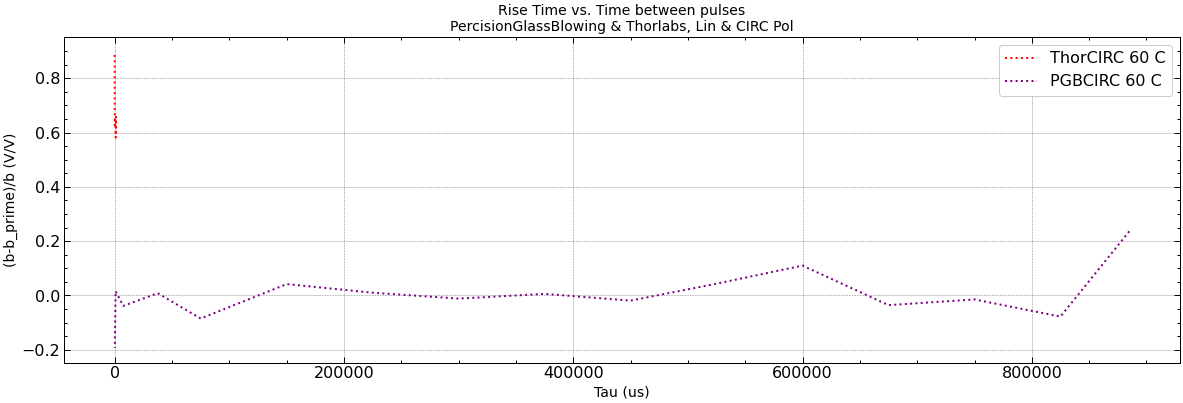

In [266]:
fig, ax = plt.subplots(figsize = (20,6), facecolor='w')

BRANDLONG = 'Thorlabs'
BRAND='Thor'

POL='CIRC'
# ax.plot(globals()[BRAND+POL+str(35)+'Tau_list'],globals()[BRAND+POL+str(35)+'b_list'], '-',label=BRAND+POL+' 35 C',color='red')
# ax.plot(globals()[BRAND+POL+str(40)+'Tau_list'],globals()[BRAND+POL+str(40)+'b_list'], '--',label=BRAND+POL+' 40 C',color='red')
ax.plot(globals()[BRAND+POL+str(60)+'Tau_list'],globals()[BRAND+POL+str(60)+'b_list'], ':',label=BRAND+POL+' 60 C',color='red')

POL='LIN'
# ax.plot(globals()[BRAND+POL+str(35)+'Tau_list'],globals()[BRAND+POL+str(35)+'b_list'], '-',label=BRAND+POL+' 35 C',color='green')
# ax.plot(globals()[BRAND+POL+str(40)+'Tau_list'],globals()[BRAND+POL+str(40)+'b_list'], '--',label=BRAND+POL+' 40 C',color='green')
# ax.plot(globals()[BRAND+POL+str(60)+'Tau_list'],globals()[BRAND+POL+str(60)+'b_list'], ':',label=BRAND+POL+' 60 C',color='green')

BRANDLONG = 'PrecisionGlassBlowing'
BRAND='PGB'

POL='CIRC'
# ax.plot(globals()[BRAND+POL+str(35)+'Tau_list'],globals()[BRAND+POL+str(35)+'b_list'], '-',label=BRAND+POL+' 35 C')
# ax.plot(globals()[BRAND+POL+str(40)+'Tau_list'],globals()[BRAND+POL+str(40)+'b_list'], '--',label=BRAND+POL+' 40 C',color='purple')
ax.plot(globals()[BRAND+POL+str(60)+'Tau_list'],globals()[BRAND+POL+str(60)+'b_list'], ':',label=BRAND+POL+' 60 C',color='purple')

POL='LIN'
# ax.plot(globals()[BRAND+POL+str(35)+'Tau_list'],globals()[BRAND+POL+str(35)+'b_list'], '-',label=BRAND+POL+' 35 C',color='orange')
# ax.plot(globals()[BRAND+POL+str(40)+'Tau_list'],globals()[BRAND+POL+str(40)+'b_list'], '--',label=BRAND+POL+' 40 C',color='orange')
# ax.plot(globals()[BRAND+POL+str(60)+'Tau_list'],globals()[BRAND+POL+str(60)+'b_list'], ':',label=BRAND+POL+' 60 C',color='orange')


ax.set_xlabel('Tau (us)', fontsize=14)
ax.set_ylabel('(b-b_prime)/b (V/V)', fontsize=14)
# ax.invert_xaxis()
# ax.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
ax.legend(loc="upper right")
ax.set_title('Rise Time vs. Time between pulses\nPercisionGlassBlowing & Thorlabs, Lin & CIRC Pol',  fontsize=14)
# plt.savefig("/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/bvTau_PGB&Thor_CIRC.png")

In [162]:
# BRANDLONG = 'Thorlabs'
# BRAND = 'Thor'
# POL = 'LIN'
# TEMP = '60' 

# for num in filenums:
transmission_file = (root+ f'/Transmission_relaxation_time_{TEMP}C_Phase_Locked.xlsx')
# Transmission_relataxion_time_CIRC_35C.xlsx
# Transmission_PGB_35C.xlsx

In [163]:
transmission_df = pd.read_excel(transmission_file)
 
# print(transmission_df)

In [164]:
transmission_df['Transmission (%)'] = (transmission_df['Cell (mV_pp)'] / transmission_df['No Cell (mV_pp)'])*100

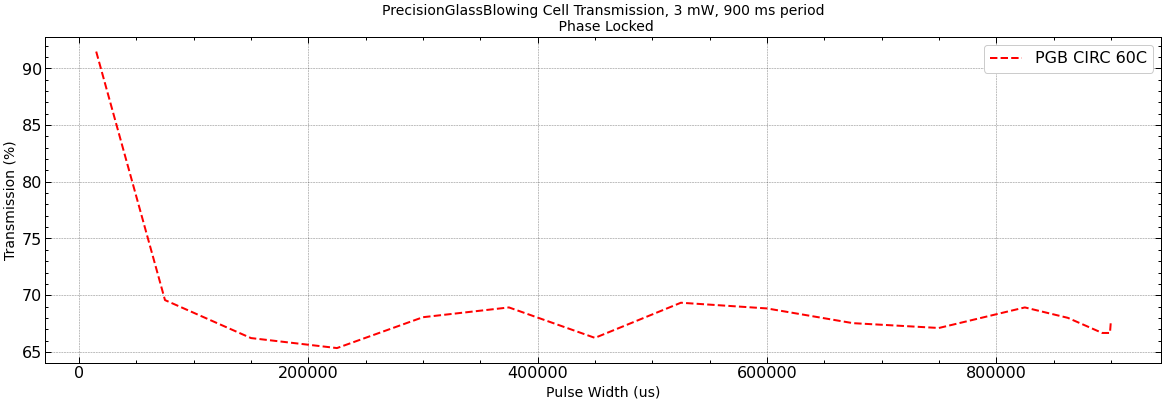

In [165]:
fig, ax = plt.subplots(figsize = (20,6), facecolor='w')
ax.plot(transmission_df['Pulse Width (us)'] , transmission_df['Transmission (%)'], '--',label=BRAND+' '+POL+' '+TEMP+'C',color='red')
ax.set_xlabel('Pulse Width (us)', fontsize=14)
ax.set_ylabel('Transmission (%)', fontsize=14)
# ax.invert_xaxis()
# ax.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
ax.legend(loc="best")
ax.set_title(BRANDLONG+f' Cell Transmission, 3 mW, {str(int(period_us/10**3))} ms period\n Phase Locked',  fontsize=14)
plt.savefig(root+ f"/Transmission_relataxion_time_{POL}_{TEMP}C_Phase_Locked.png")

In [24]:
def transmission(file, BRAND, POL, TEMP):
    globals()[BRAND+POL+TEMP+"_RT_df"] = pd.read_excel(file)
    globals()[BRAND+POL+TEMP+"_RT_df"]['Transmission (%)'] = (globals()[BRAND+POL+TEMP+"_RT_df"]['Cell (mV_pp)'] / globals()[BRAND+POL+TEMP+"_RT_df"]['No Cell (mV_pp)'])*100
    return None

In [25]:
BRANDLONG = 'PrecisionGlassBlowing'
BRAND='PGB'

POL='CIRC'

TEMP='35'
transmission_file = ("/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/"
             +BRANDLONG+"/"+POL+"POL/relaxation_time_"+TEMP+"C/Transmission_relaxation_time_"+POL+"_"+TEMP+"C.xlsx")
transmission(transmission_file, BRAND, POL, TEMP)

TEMP='40'
transmission_file = ("/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/"
             +BRANDLONG+"/"+POL+"POL/relaxation_time_"+TEMP+"C/Transmission_relaxation_time_"+POL+"_"+TEMP+"C.xlsx")
transmission(transmission_file, BRAND, POL, TEMP)


TEMP='60'
transmission_file = ("/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/"
             +BRANDLONG+"/"+POL+"POL/relaxation_time_"+TEMP+"C/Transmission_relaxation_time_"+POL+"_"+TEMP+"C.xlsx")
transmission(transmission_file, BRAND, POL, TEMP)

POL='LIN'

TEMP='35'
transmission_file = ("/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/"
             +BRANDLONG+"/"+POL+"POL/relaxation_time_"+TEMP+"C/Transmission_relaxation_time_"+POL+"_"+TEMP+"C.xlsx")
transmission(transmission_file, BRAND, POL, TEMP)

TEMP='40'
transmission_file = ("/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/"
             +BRANDLONG+"/"+POL+"POL/relaxation_time_"+TEMP+"C/Transmission_relaxation_time_"+POL+"_"+TEMP+"C.xlsx")
transmission(transmission_file, BRAND, POL, TEMP)

TEMP='60'
transmission_file = ("/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/"
             +BRANDLONG+"/"+POL+"POL/relaxation_time_"+TEMP+"C/Transmission_relaxation_time_"+POL+"_"+TEMP+"C.xlsx")
transmission(transmission_file, BRAND, POL, TEMP)

In [26]:
BRANDLONG = 'Thorlabs'
BRAND='Thor'

POL='CIRC'

TEMP='35'
transmission_file = ("/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/"
             +BRANDLONG+"/"+POL+"POL/relaxation_time_"+TEMP+"C/Transmission_relaxation_time_"+POL+"_"+TEMP+"C.xlsx")
transmission(transmission_file, BRAND, POL, TEMP)

TEMP='40'
transmission_file = ("/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/"
             +BRANDLONG+"/"+POL+"POL/relaxation_time_"+TEMP+"C/Transmission_relaxation_time_"+POL+"_"+TEMP+"C.xlsx")
transmission(transmission_file, BRAND, POL, TEMP)


TEMP='60'
transmission_file = ("/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/"
             +BRANDLONG+"/"+POL+"POL/relaxation_time_"+TEMP+"C/Transmission_relaxation_time_"+POL+"_"+TEMP+"C.xlsx")
transmission(transmission_file, BRAND, POL, TEMP)

POL='LIN'

TEMP='35'
transmission_file = ("/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/"
             +BRANDLONG+"/"+POL+"POL/relaxation_time_"+TEMP+"C/Transmission_relaxation_time_"+POL+"_"+TEMP+"C.xlsx")
transmission(transmission_file, BRAND, POL, TEMP)

TEMP='40'
transmission_file = ("/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/"
             +BRANDLONG+"/"+POL+"POL/relaxation_time_"+TEMP+"C/Transmission_relaxation_time_"+POL+"_"+TEMP+"C.xlsx")
transmission(transmission_file, BRAND, POL, TEMP)

TEMP='60'
transmission_file = ("/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/"
             +BRANDLONG+"/"+POL+"POL/relaxation_time_"+TEMP+"C/Transmission_relaxation_time_"+POL+"_"+TEMP+"C.xlsx")
transmission(transmission_file, BRAND, POL, TEMP)

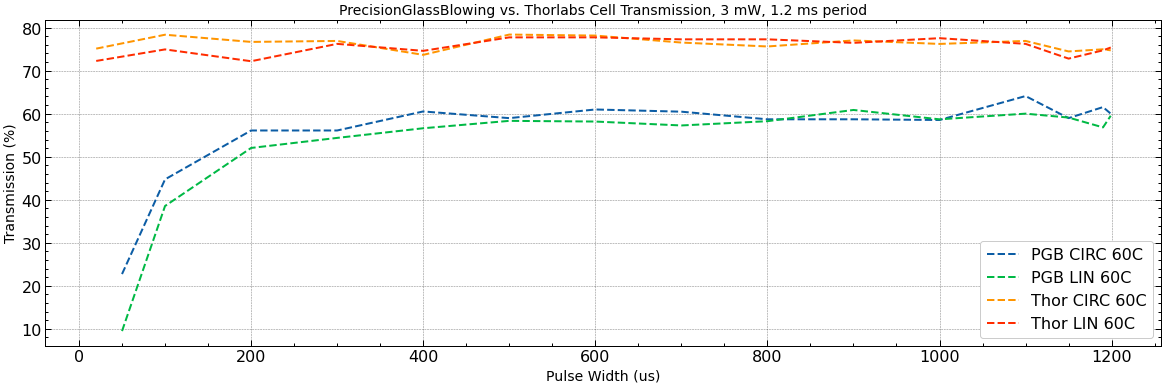

In [27]:
fig, ax = plt.subplots(figsize = (20,6), facecolor='w')
BRANDLONG = 'PrecisionGlassBlowing'
BRAND='PGB'
POL='CIRC'
TEMP='35'
# ax.plot(globals()[BRAND+POL+TEMP+"_RT_df"]['Pulse Width (us)'] , globals()[BRAND+POL+TEMP+"_RT_df"]['Transmission (%)'], '--',label=BRAND+' '+POL+' '+TEMP+'C')
TEMP='40'
# ax.plot(globals()[BRAND+POL+TEMP+"_RT_df"]['Pulse Width (us)'] , globals()[BRAND+POL+TEMP+"_RT_df"]['Transmission (%)'], '--',label=BRAND+' '+POL+' '+TEMP+'C')
TEMP='60'
ax.plot(globals()[BRAND+POL+TEMP+"_RT_df"]['Pulse Width (us)'] , globals()[BRAND+POL+TEMP+"_RT_df"]['Transmission (%)'], '--',label=BRAND+' '+POL+' '+TEMP+'C')
POL='LIN'
TEMP='35'
# ax.plot(globals()[BRAND+POL+TEMP+"_RT_df"]['Pulse Width (us)'] , globals()[BRAND+POL+TEMP+"_RT_df"]['Transmission (%)'], '--',label=BRAND+' '+POL+' '+TEMP+'C')
TEMP='40'
# ax.plot(globals()[BRAND+POL+TEMP+"_RT_df"]['Pulse Width (us)'] , globals()[BRAND+POL+TEMP+"_RT_df"]['Transmission (%)'], '--',label=BRAND+' '+POL+' '+TEMP+'C')
TEMP='60'
ax.plot(globals()[BRAND+POL+TEMP+"_RT_df"]['Pulse Width (us)'] , globals()[BRAND+POL+TEMP+"_RT_df"]['Transmission (%)'], '--',label=BRAND+' '+POL+' '+TEMP+'C')

BRANDLONG = 'Thorlabs'
BRAND='Thor'
POL='CIRC'
TEMP='35'
# ax.plot(globals()[BRAND+POL+TEMP+"_RT_df"]['Pulse Width (us)'] , globals()[BRAND+POL+TEMP+"_RT_df"]['Transmission (%)'], '--',label=BRAND+' '+POL+' '+TEMP+'C')
TEMP='40'
# ax.plot(globals()[BRAND+POL+TEMP+"_RT_df"]['Pulse Width (us)'] , globals()[BRAND+POL+TEMP+"_RT_df"]['Transmission (%)'], '--',label=BRAND+' '+POL+' '+TEMP+'C')
TEMP='60'
ax.plot(globals()[BRAND+POL+TEMP+"_RT_df"]['Pulse Width (us)'] , globals()[BRAND+POL+TEMP+"_RT_df"]['Transmission (%)'], '--',label=BRAND+' '+POL+' '+TEMP+'C')
POL='LIN'
TEMP='35'
# ax.plot(globals()[BRAND+POL+TEMP+"_RT_df"]['Pulse Width (us)'] , globals()[BRAND+POL+TEMP+"_RT_df"]['Transmission (%)'], '--',label=BRAND+' '+POL+' '+TEMP+'C')
TEMP='40'
# ax.plot(globals()[BRAND+POL+TEMP+"_RT_df"]['Pulse Width (us)'] , globals()[BRAND+POL+TEMP+"_RT_df"]['Transmission (%)'], '--',label=BRAND+' '+POL+' '+TEMP+'C')
TEMP='60'
ax.plot(globals()[BRAND+POL+TEMP+"_RT_df"]['Pulse Width (us)'] , globals()[BRAND+POL+TEMP+"_RT_df"]['Transmission (%)'], '--',label=BRAND+' '+POL+' '+TEMP+'C')
ax.set_xlabel('Pulse Width (us)', fontsize=14)
ax.set_ylabel('Transmission (%)', fontsize=14)
# ax.invert_xaxis()
# ax.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
ax.legend(loc="best")
# ax.set_title(BRANDLONG+' Cell Transmission, 3 mW, 1.2 ms period',  fontsize=14)
ax.set_title('PrecisionGlassBlowing vs. Thorlabs Cell Transmission, 3 mW, 12 ms period\n Phase Locked',  fontsize=14)
# plt.savefig("/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/"
#              +BRANDLONG+"/"+POL+"POL/relaxation_time_"+TEMP+"C/Transmission_relataxion_time_60C.png")
plt.savefig("/mnt/e/Google_Drive_Backup_E/Data/Magnetometery/OpticalPumping/Transmission_relataxion_time_60C.png")